In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
import deepdish as dd
from itertools import compress

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
hw_cw_data = dd.io.load('2018_2_14_hws_cws_data.h5')
contour_data = dd.io.load('2018_2_14_contour_plot_data.h5')

In [3]:
hw_cw_data.keys()

dict_keys(['cws', 'hws', 'infos'])

In [4]:
contour_data.keys()

dict_keys(['data_multicell_info', 'data_singlecell_info', 'multi_cell_info', 'single_cell_info'])

In [5]:
data_multicell_info = contour_data['data_multicell_info']
data_singlecell_info = contour_data['data_singlecell_info']
multi_cell_info = contour_data['multi_cell_info']
single_cell_info = contour_data['single_cell_info']

In [6]:
def unravel_polyfit(p, x):
    unraveled = []
    degs = np.arange(len(p))[::-1]
    for xi in x:
        term = 0.0
        for pi, deg in zip(p, degs):
            term += pi * xi**deg
        unraveled.append(term)
    return unraveled

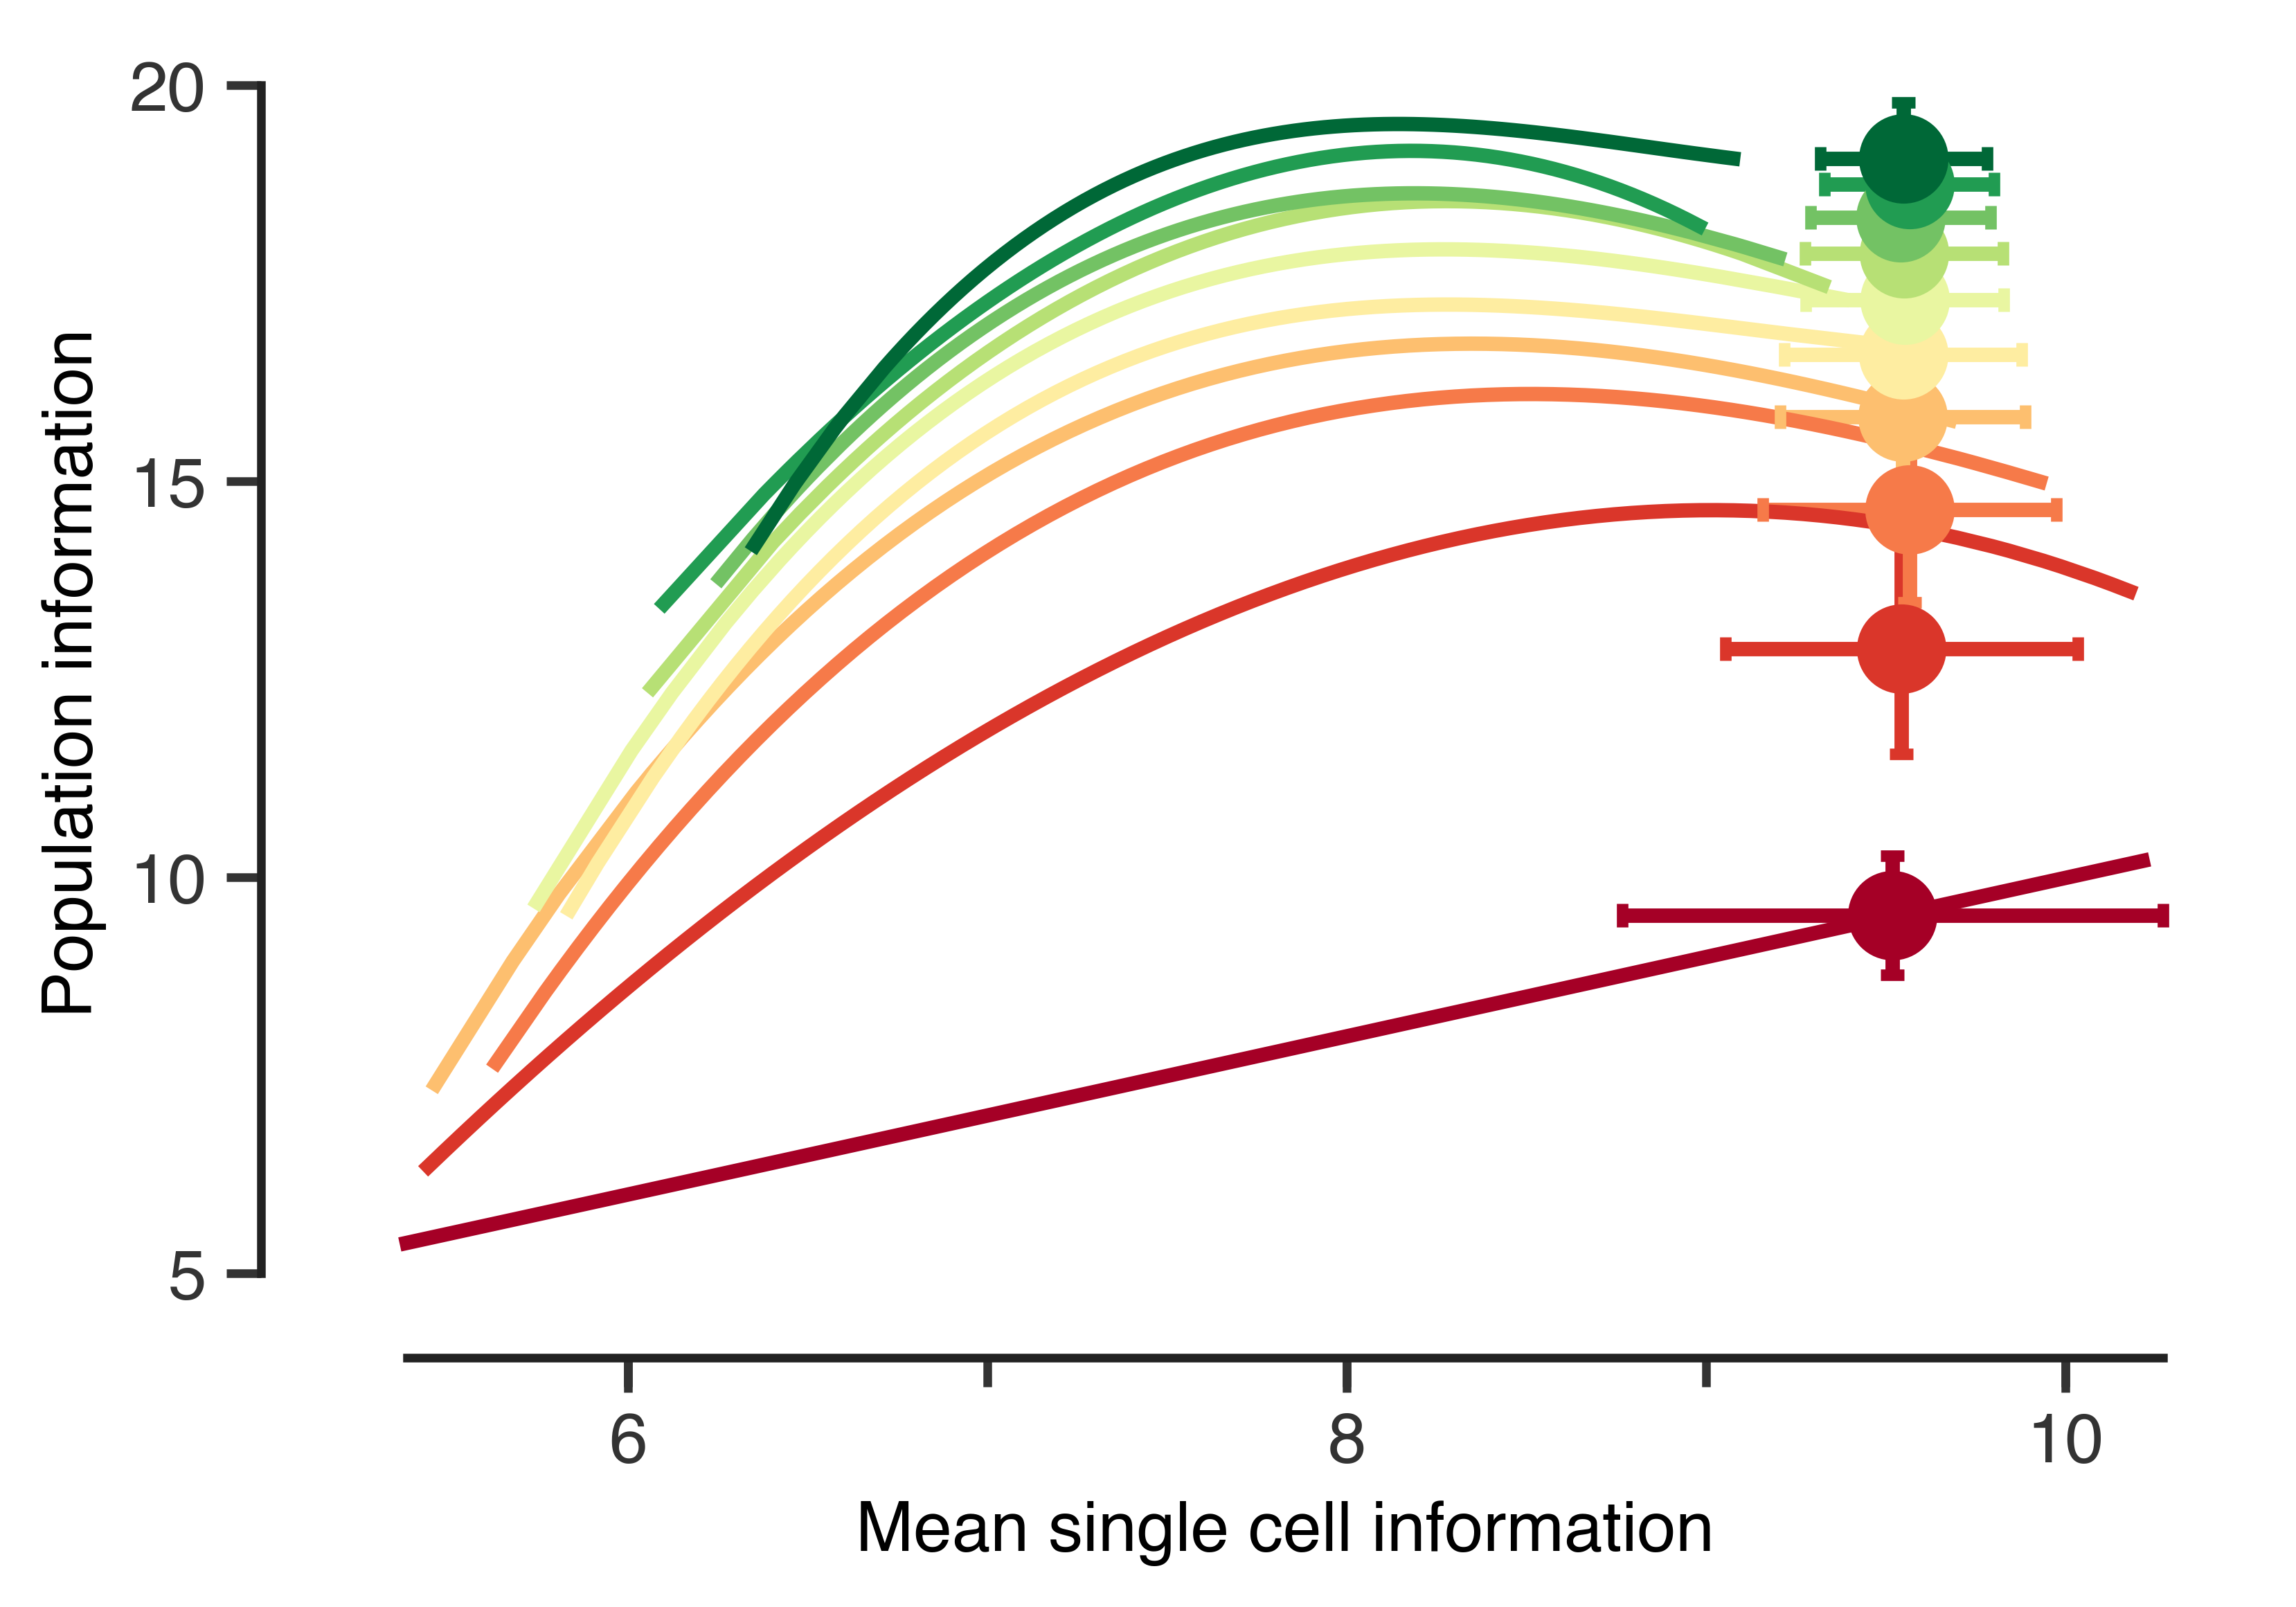

In [7]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 10))

bin_size = [100]
deg = 3
for i in range(1, 11):
    for s in bin_size:
        single_bins = np.linspace(np.min(single_cell_info[i]), np.max(single_cell_info[i]), s + 1)
        if i == 1:
            range_of_bins = single_bins
        max_multi_info = []
        for k, b in enumerate(single_bins[:-1]):
            relevant_indices = (b <= single_cell_info[i]) * (single_bins[k + 1] > single_cell_info[i])
            relevant_single_info = list(compress(single_cell_info[i], relevant_indices))
            if relevant_single_info:
                max_multi_info.append(max(list(compress(multi_cell_info[i], relevant_indices))))
            else:
                max_multi_info.append(None)
                
        remaining_idxs = [idx for idx in range(len(max_multi_info)) if max_multi_info[idx]]
        remaining_maxs = np.array(max_multi_info)[remaining_idxs]
        remaining_bins = single_bins[1:][remaining_idxs]
        p = np.polyfit(remaining_bins, remaining_maxs, deg)
        plt.plot(remaining_bins, unravel_polyfit(p, remaining_bins), label=f'filters={i}, bins={s}',
                 color=colors[i-1])
#         plt.plot(range_of_bins, unravel_polyfit(p, range_of_bins), label=f'filters={i}, bins={s}',
#                  color=colors[i-1])
        
        plt.errorbar(np.mean(data_singlecell_info[i]), np.mean(data_multicell_info[i]),
                     yerr=np.std(data_multicell_info[i]), xerr=np.std(data_singlecell_info[i]),
                     fmt='o', ecolor=colors[i-1], color=colors[i-1], capthick=2, capsize=2)
#     plt.legend(frameon=False, loc='lower right')

majorLocator = MultipleLocator(5)
majorLocatorx = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_major_locator(majorLocatorx)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)

adjust_spines(plt.gca())
plt.xlabel('Mean single cell information')
plt.ylabel('Population information')

In [8]:
info_comparison = dd.io.load('2018_2_14_info_comparison.h5')

In [9]:
info_comparison.keys()

dict_keys(['global_opt', 'mean_data_info_vs_filters', 'sem_data_info_vs_filters', 'single_cell_opt', 'varied_cw_fixed_hw', 'varied_hw_fixed_cw'])

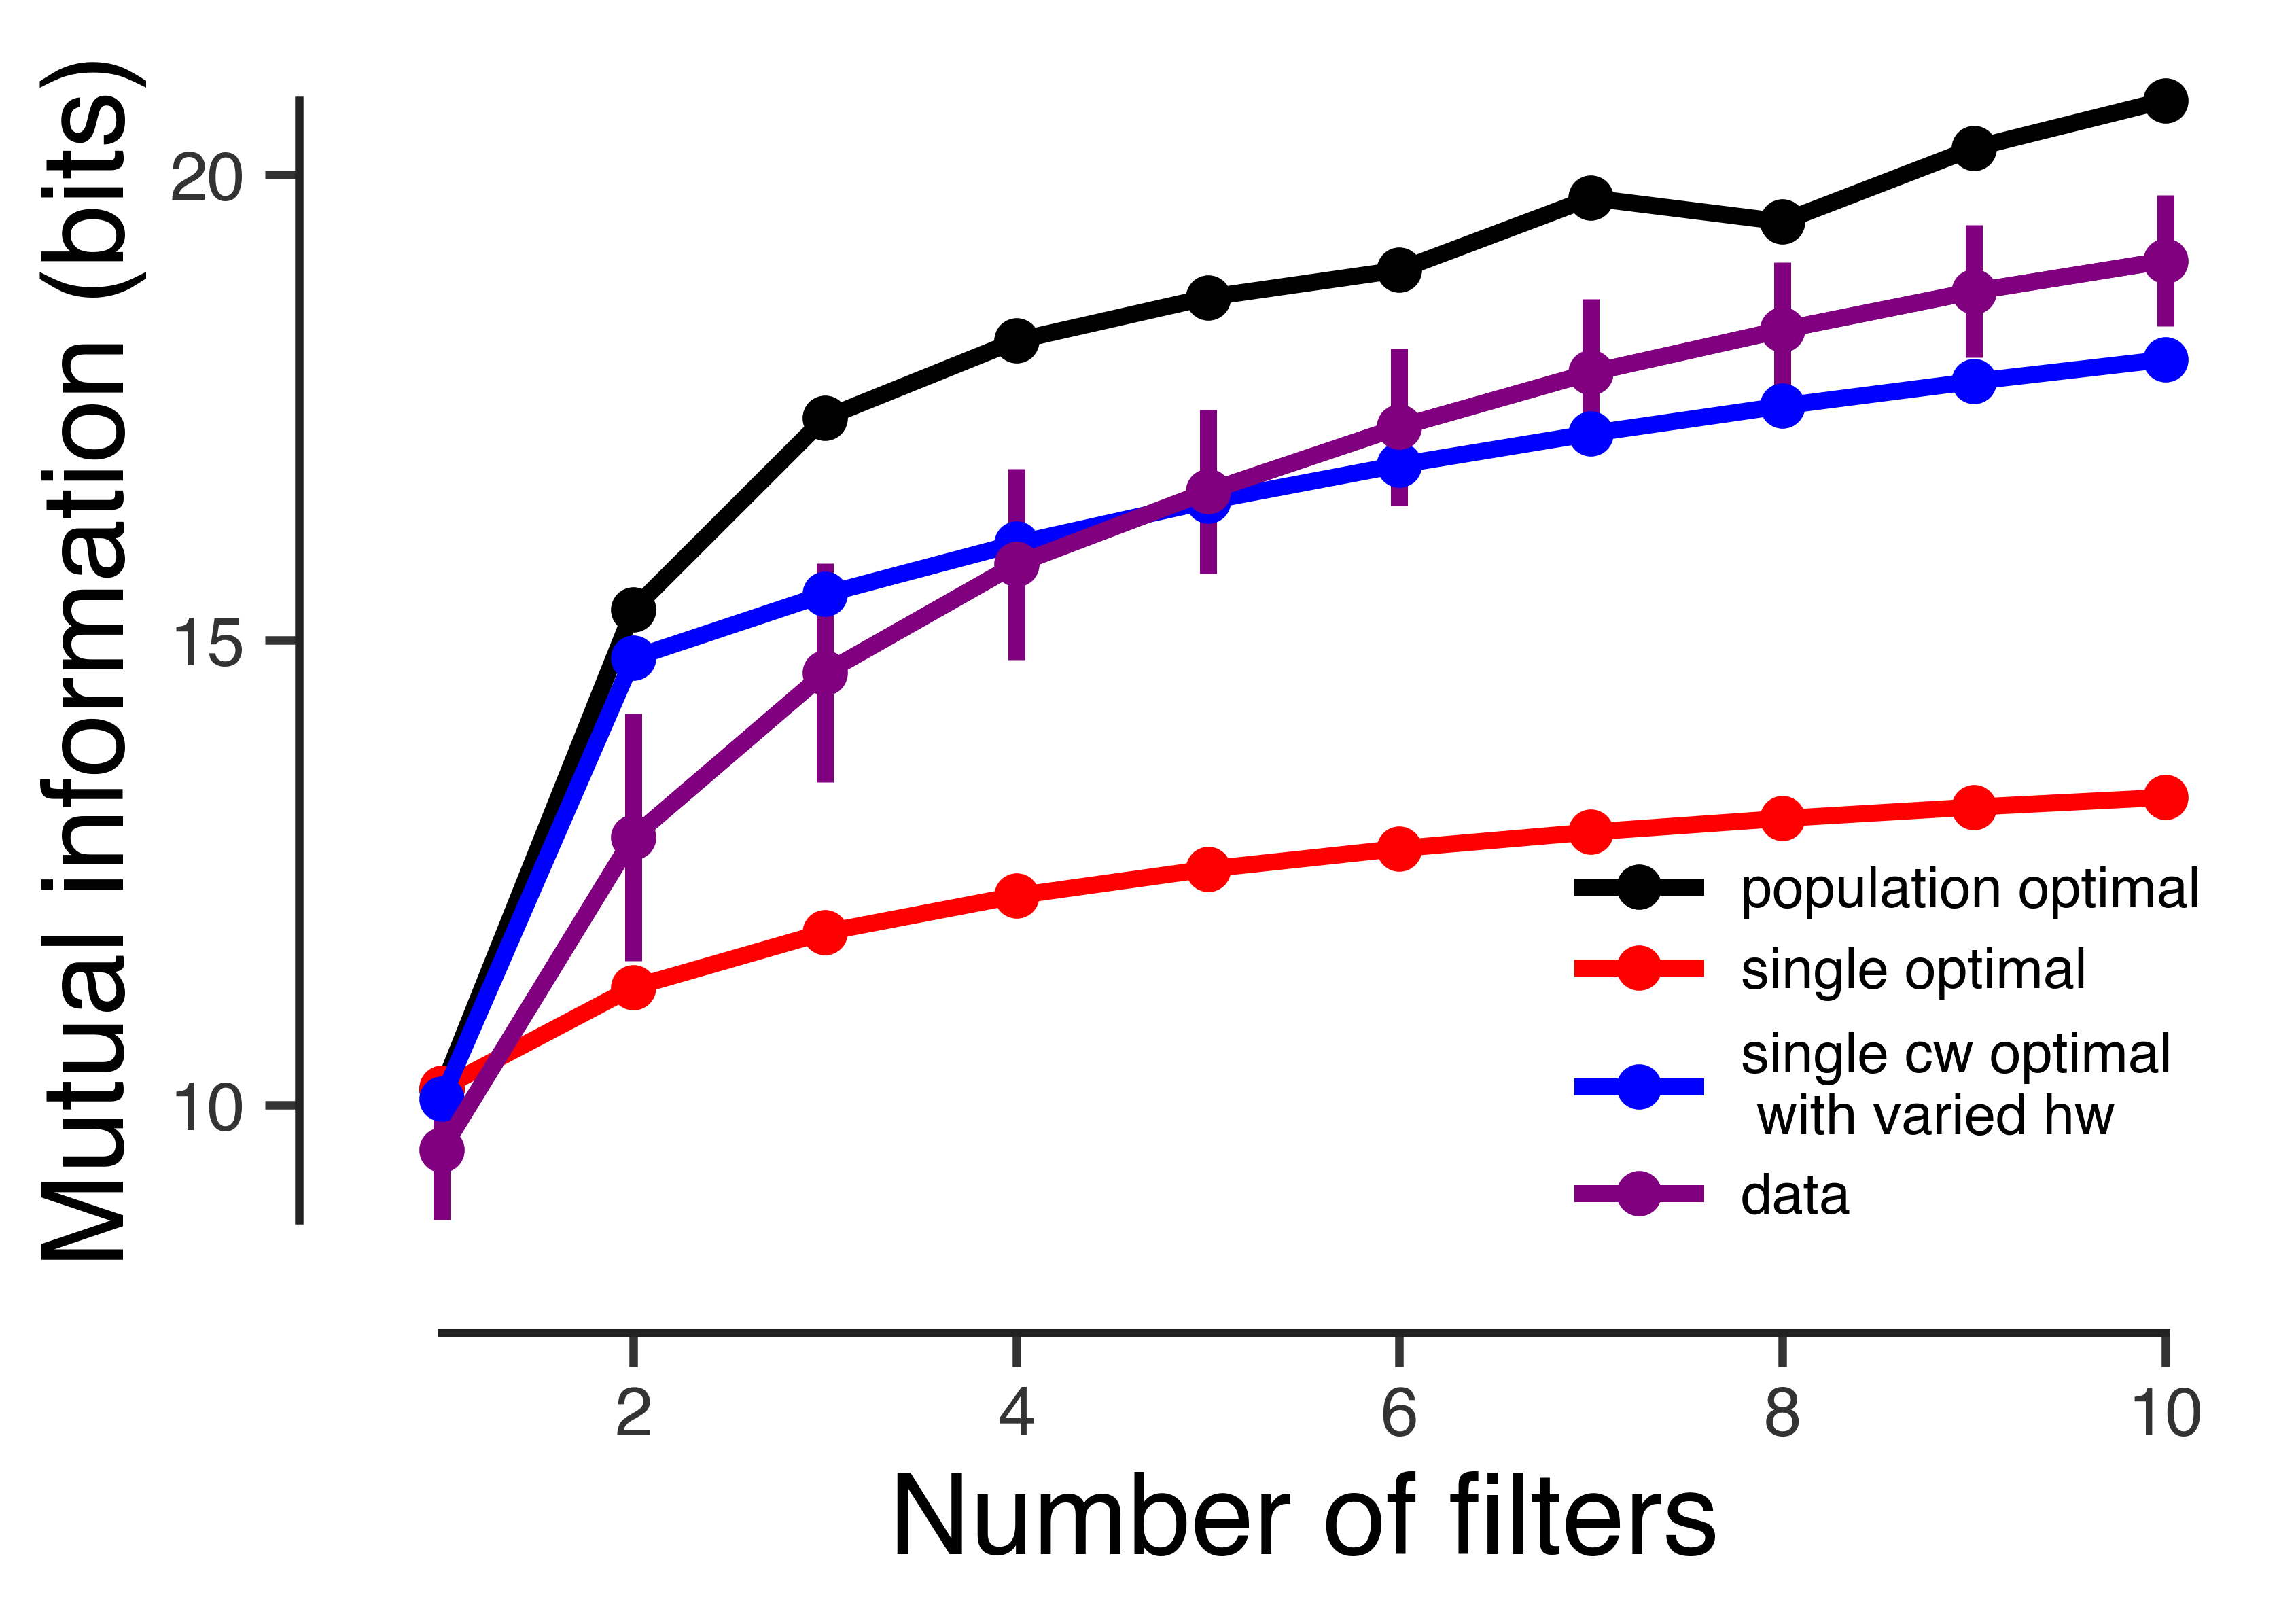

In [10]:
plt.plot(np.arange(1,11), info_comparison['global_opt'], 'k', linewidth=3, marker='.', 
         markersize=15, label='population optimal')
plt.plot(np.arange(1,11), info_comparison['single_cell_opt'], 'r', linewidth=3, marker='.', 
         markersize=15, label='single optimal')
plt.plot(np.arange(1,11), info_comparison['varied_hw_fixed_cw'], 'b', linewidth=3, marker='.', 
         markersize=15, label='single cw optimal \n with varied hw')
# plt.plot(np.arange(1,11), splitting_cws_fun, 'c', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), info_comparison['mean_data_info_vs_filters'], linewidth=3,
         color='purple', marker='.', markersize=15, label='data')
plt.errorbar(np.arange(1,11), info_comparison['mean_data_info_vs_filters'], 
             yerr=[np.std(data_multicell_info[i]) for i in range(1, 11)], linewidth=3, color='purple')
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
plt.legend(loc='lower right', frameon=False, fontsize=10)
# plt.ylim(5, 22)

majorLocator = MultipleLocator(5)
majorLocatorx = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_major_locator(majorLocatorx)
# ax.xaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_minor_locator(minorLocator)

adjust_spines(plt.gca())

## We want to add an extra line to this plot denoting the population optimal when we allow the sizes of horizontal and amacrine cell contributions to vary (currently its fixed to the data).

In [11]:
constants = np.load(os.path.expanduser('~/data/surround/2017_10_9_diversity_constants.npy')).item()
signal = np.array(np.load(os.path.expanduser('~/data/surround/signal_3_23.npy')))

In [12]:
space = constants['space']
center = constants['center']
horz_pf = constants['horz_pf']
ama_pf = constants['ama_pf']
input_noise = constants['input_noise']
output_noise = constants['output_noise']
target_power = constants['target_power']

In [13]:
def normalized_gaussian(x, sigma):
    g = gaussian(x=x, sigma=sigma)
    return g / g.max()

In [14]:
def variable_rf_model(horz_weight, center_weight, horz_width, ama_width):
    return center_weight*center + (1-center_weight) * (
        horz_weight * normalized_gaussian(x=space, sigma=horz_width) + (
            1-horz_weight) * normalized_gaussian(x=space, sigma=ama_width))

In [15]:
def generate_spatial_signals(batch_size, signal=signal):
    # We generate white noise sequences, then multiply their frequency spectra
    # by the signal frequency spectra to make it look like a natural sequence.
    random_seq = [np.random.randn(2 * len(signal) - 1) for b in range(batch_size)]
    spatial_seq = [np.fft.irfft(np.fft.rfft(s) * signal) for s in random_seq]
    return np.stack(spatial_seq)

In [16]:
def filter_bank(hws, cws, horz_width, ama_width):
    filters_sparse = []
    for hw, cw in zip(hws, cws):
        rf_1d = variable_rf_model(hw, cw, horz_width, ama_width)
        t = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d)
        t_rev = scipy.linalg.toeplitz(np.zeros(400), r=rf_1d[::-1])[::-1, ::-1]
        filters = np.vstack([t_rev, t])[200:-200]
        filters_sparse.append(filters[40:-30:50])
    return np.vstack(filters_sparse)

In [17]:
samples = 1000
spatial_signals = generate_spatial_signals(samples)
num_repeat = 7

def neg_mutual_information(weights):
    horizontal_width = abs(weights[-2])
    amacrine_width = abs(weights[-1])
    num_filters = len(weights[:-2])//2
    hws = weights[:num_filters]
    cws = weights[num_filters:-2]
    assert len(hws) == len(cws), "HW and CW weights must be same length."
    filters = filter_bank(hws, cws, horizontal_width, amacrine_width)
    sigma_f = np.dot(filters, filters.T)
    fs = np.dot(filters[:, :-1], spatial_signals.T)
    sigma_s = np.dot(fs, fs.T)

    def sigmas(filter_constants, return_flag='sigmas'):
        if len(filter_constants) == 1:
            ff_types = filter_constants**2
            ff_const = np.ones((num_repeat, num_repeat)) * ff_types
        else:
            ff_types = np.outer(filter_constants, filter_constants)
            ff_const = np.repeat(
                np.repeat(ff_types, num_filters * [num_repeat], axis=0),
                num_filters * [num_repeat], axis=-1)

        sigma_n = input_noise**2 * ff_const * sigma_f + output_noise**2 * np.eye(ff_const.shape[0])
        sigma_signal = ff_const * sigma_s
        sigma_t = sigma_signal + sigma_n

        if return_flag == 'snr':
            signal_var = np.diag(sigma_signal)
            noise_var = np.diag(sigma_n)
            snr = signal_var/noise_var
            return snr
        elif return_flag == 'sigmas':
            return sigma_t, sigma_n
        elif return_flag == 'power':
            return np.diag(sigma_t)

    def mse_snr(filter_constants):
        snr = sigmas(filter_constants, return_flag='snr')
        return np.mean((snr - target_snr)**2)

    def mse_power(filter_constants):
        power = sigmas(filter_constants, return_flag='power')
        return np.mean((power - target_power)**2)

    res = scipy.optimize.minimize(mse_power, np.random.rand(num_filters, 1))
    opt_filter_const = abs(res.x)

    sigma_t, sigma_n = sigmas(opt_filter_const)
    chol_t = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_t))))
    chol_n = np.sum(np.log(np.diag(np.linalg.cholesky(2 * np.pi * np.exp(1) * sigma_n))))
    mi =  0.5 * (chol_t - chol_n)
    return -mi + 20

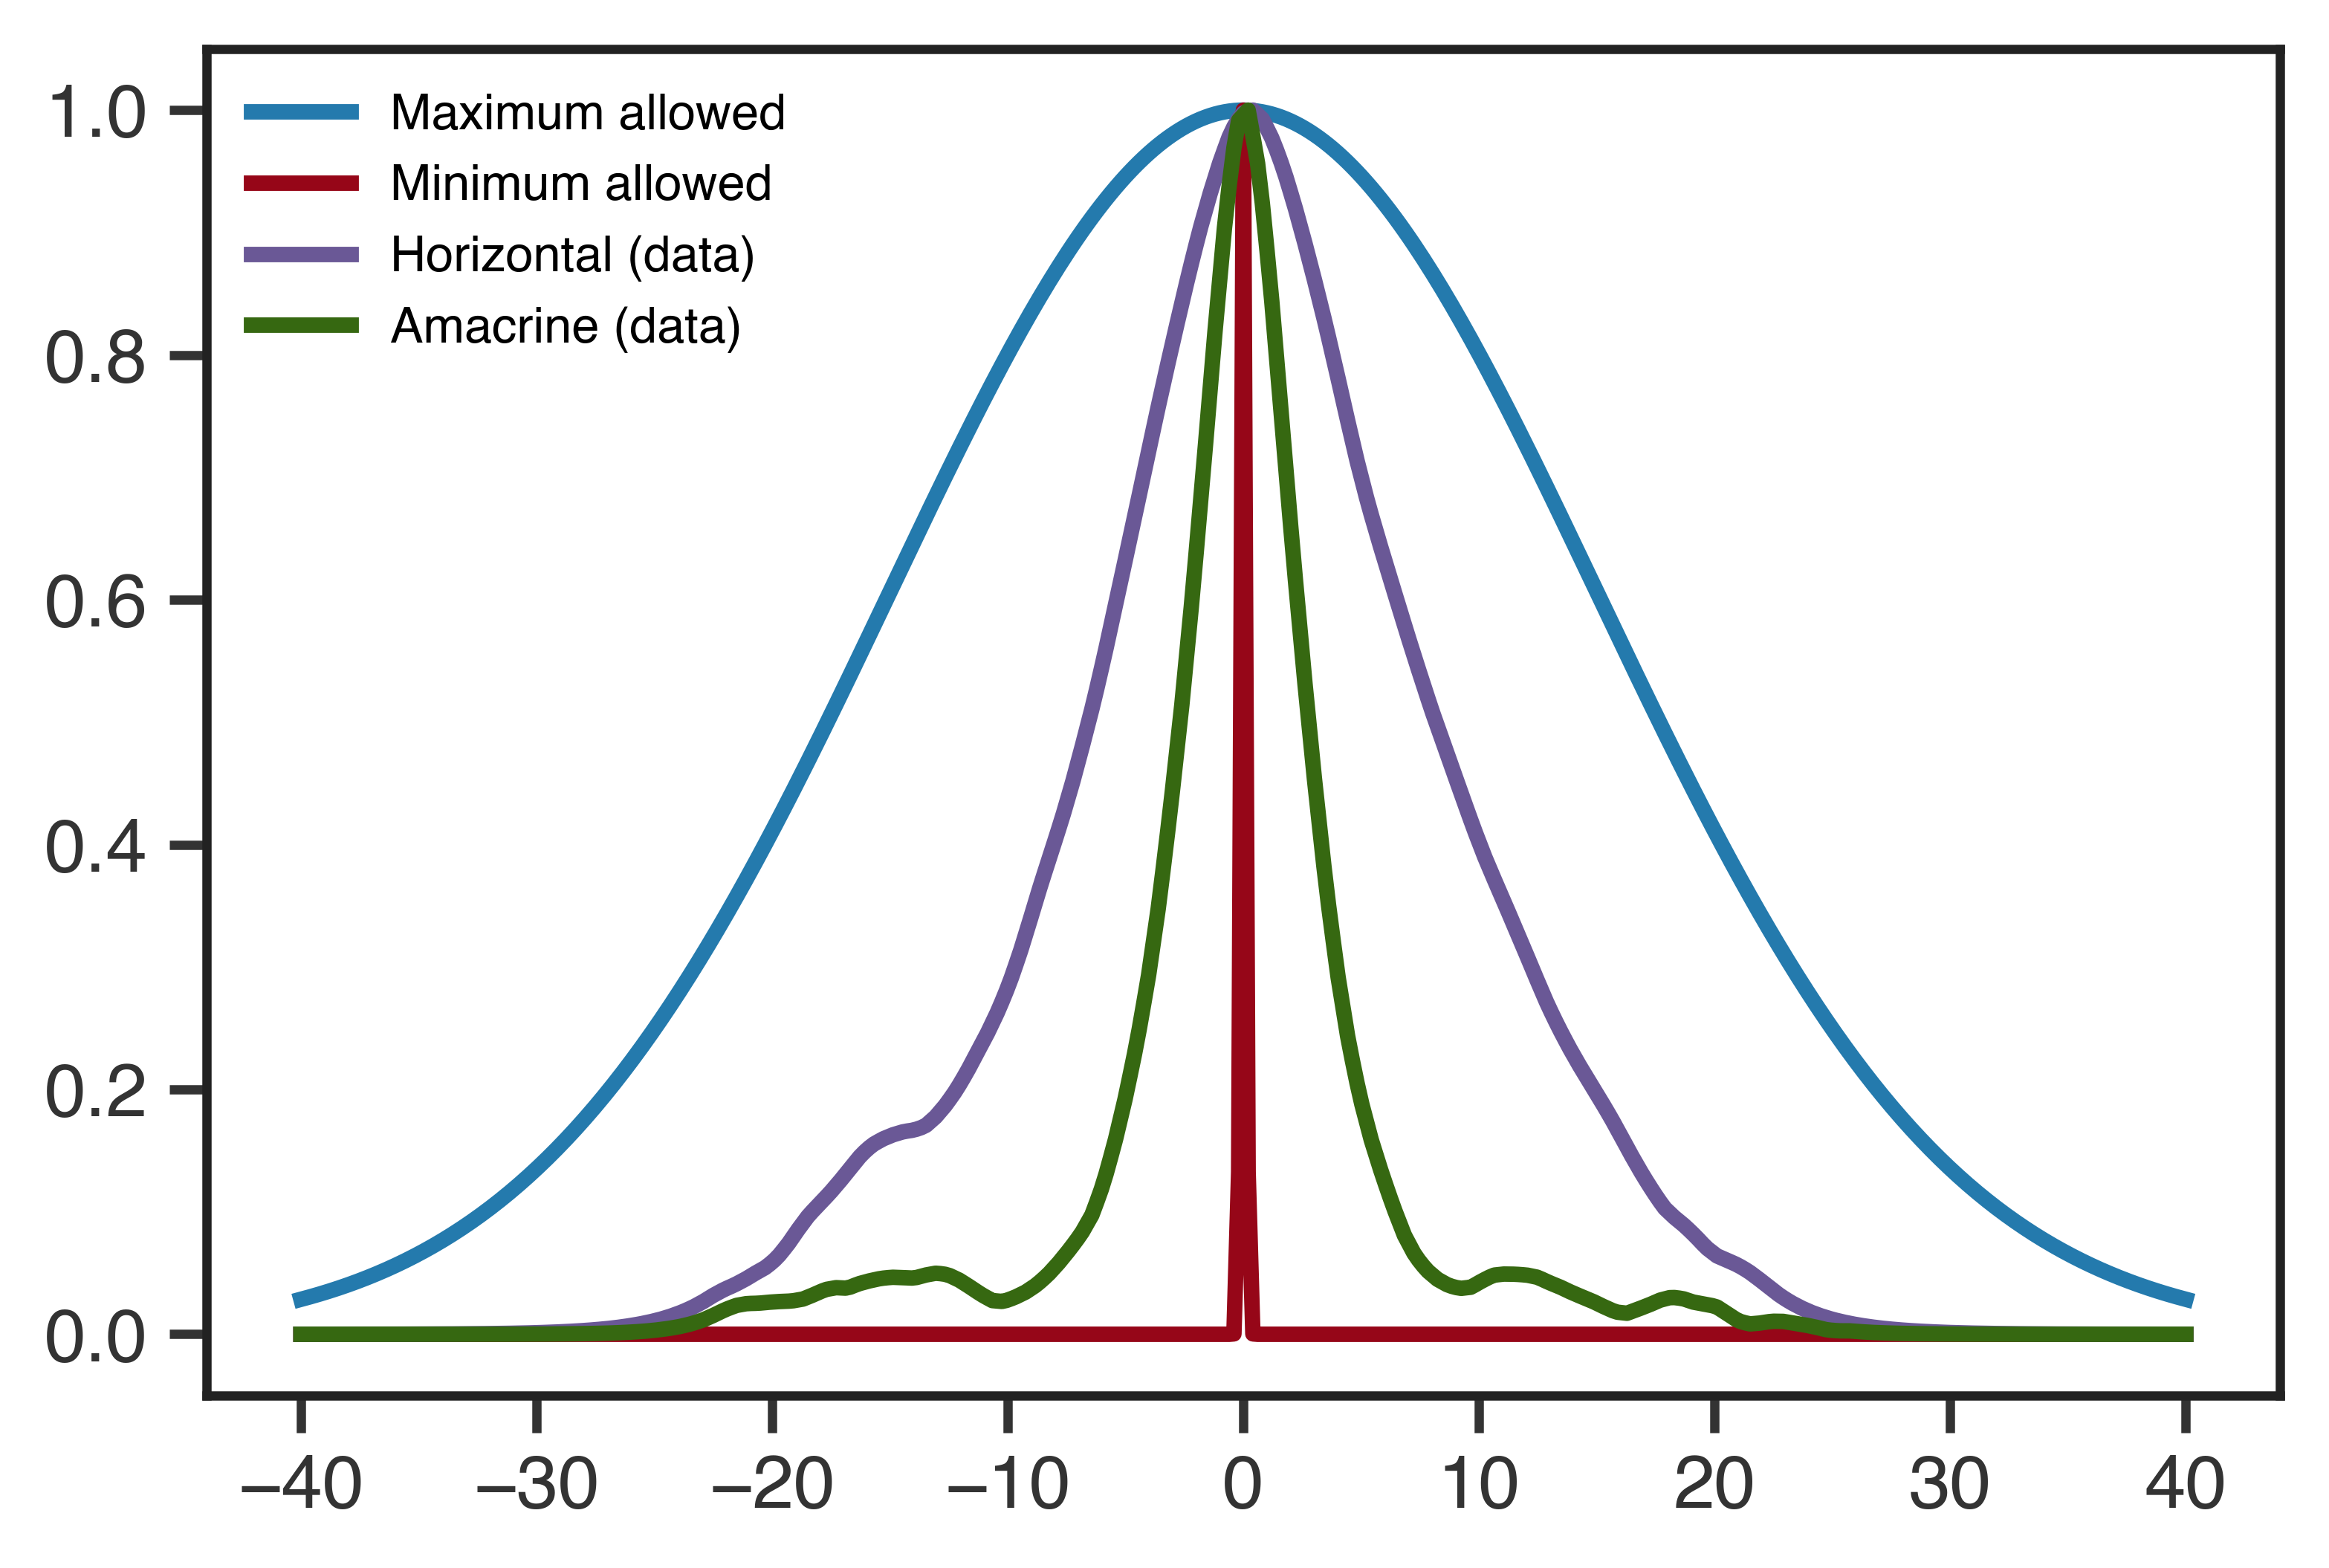

In [18]:
plt.plot(space, normalized_gaussian(x=space, sigma=15.0), label='Maximum allowed')
plt.plot(space, normalized_gaussian(x=space, sigma=0.1), label='Minimum allowed')
plt.plot(space, horz_pf/np.max(horz_pf), label='Horizontal (data)')
plt.plot(space, ama_pf/np.max(ama_pf), label='Amacrine (data)')
plt.legend(frameon=False, fontsize=8, loc='upper left')

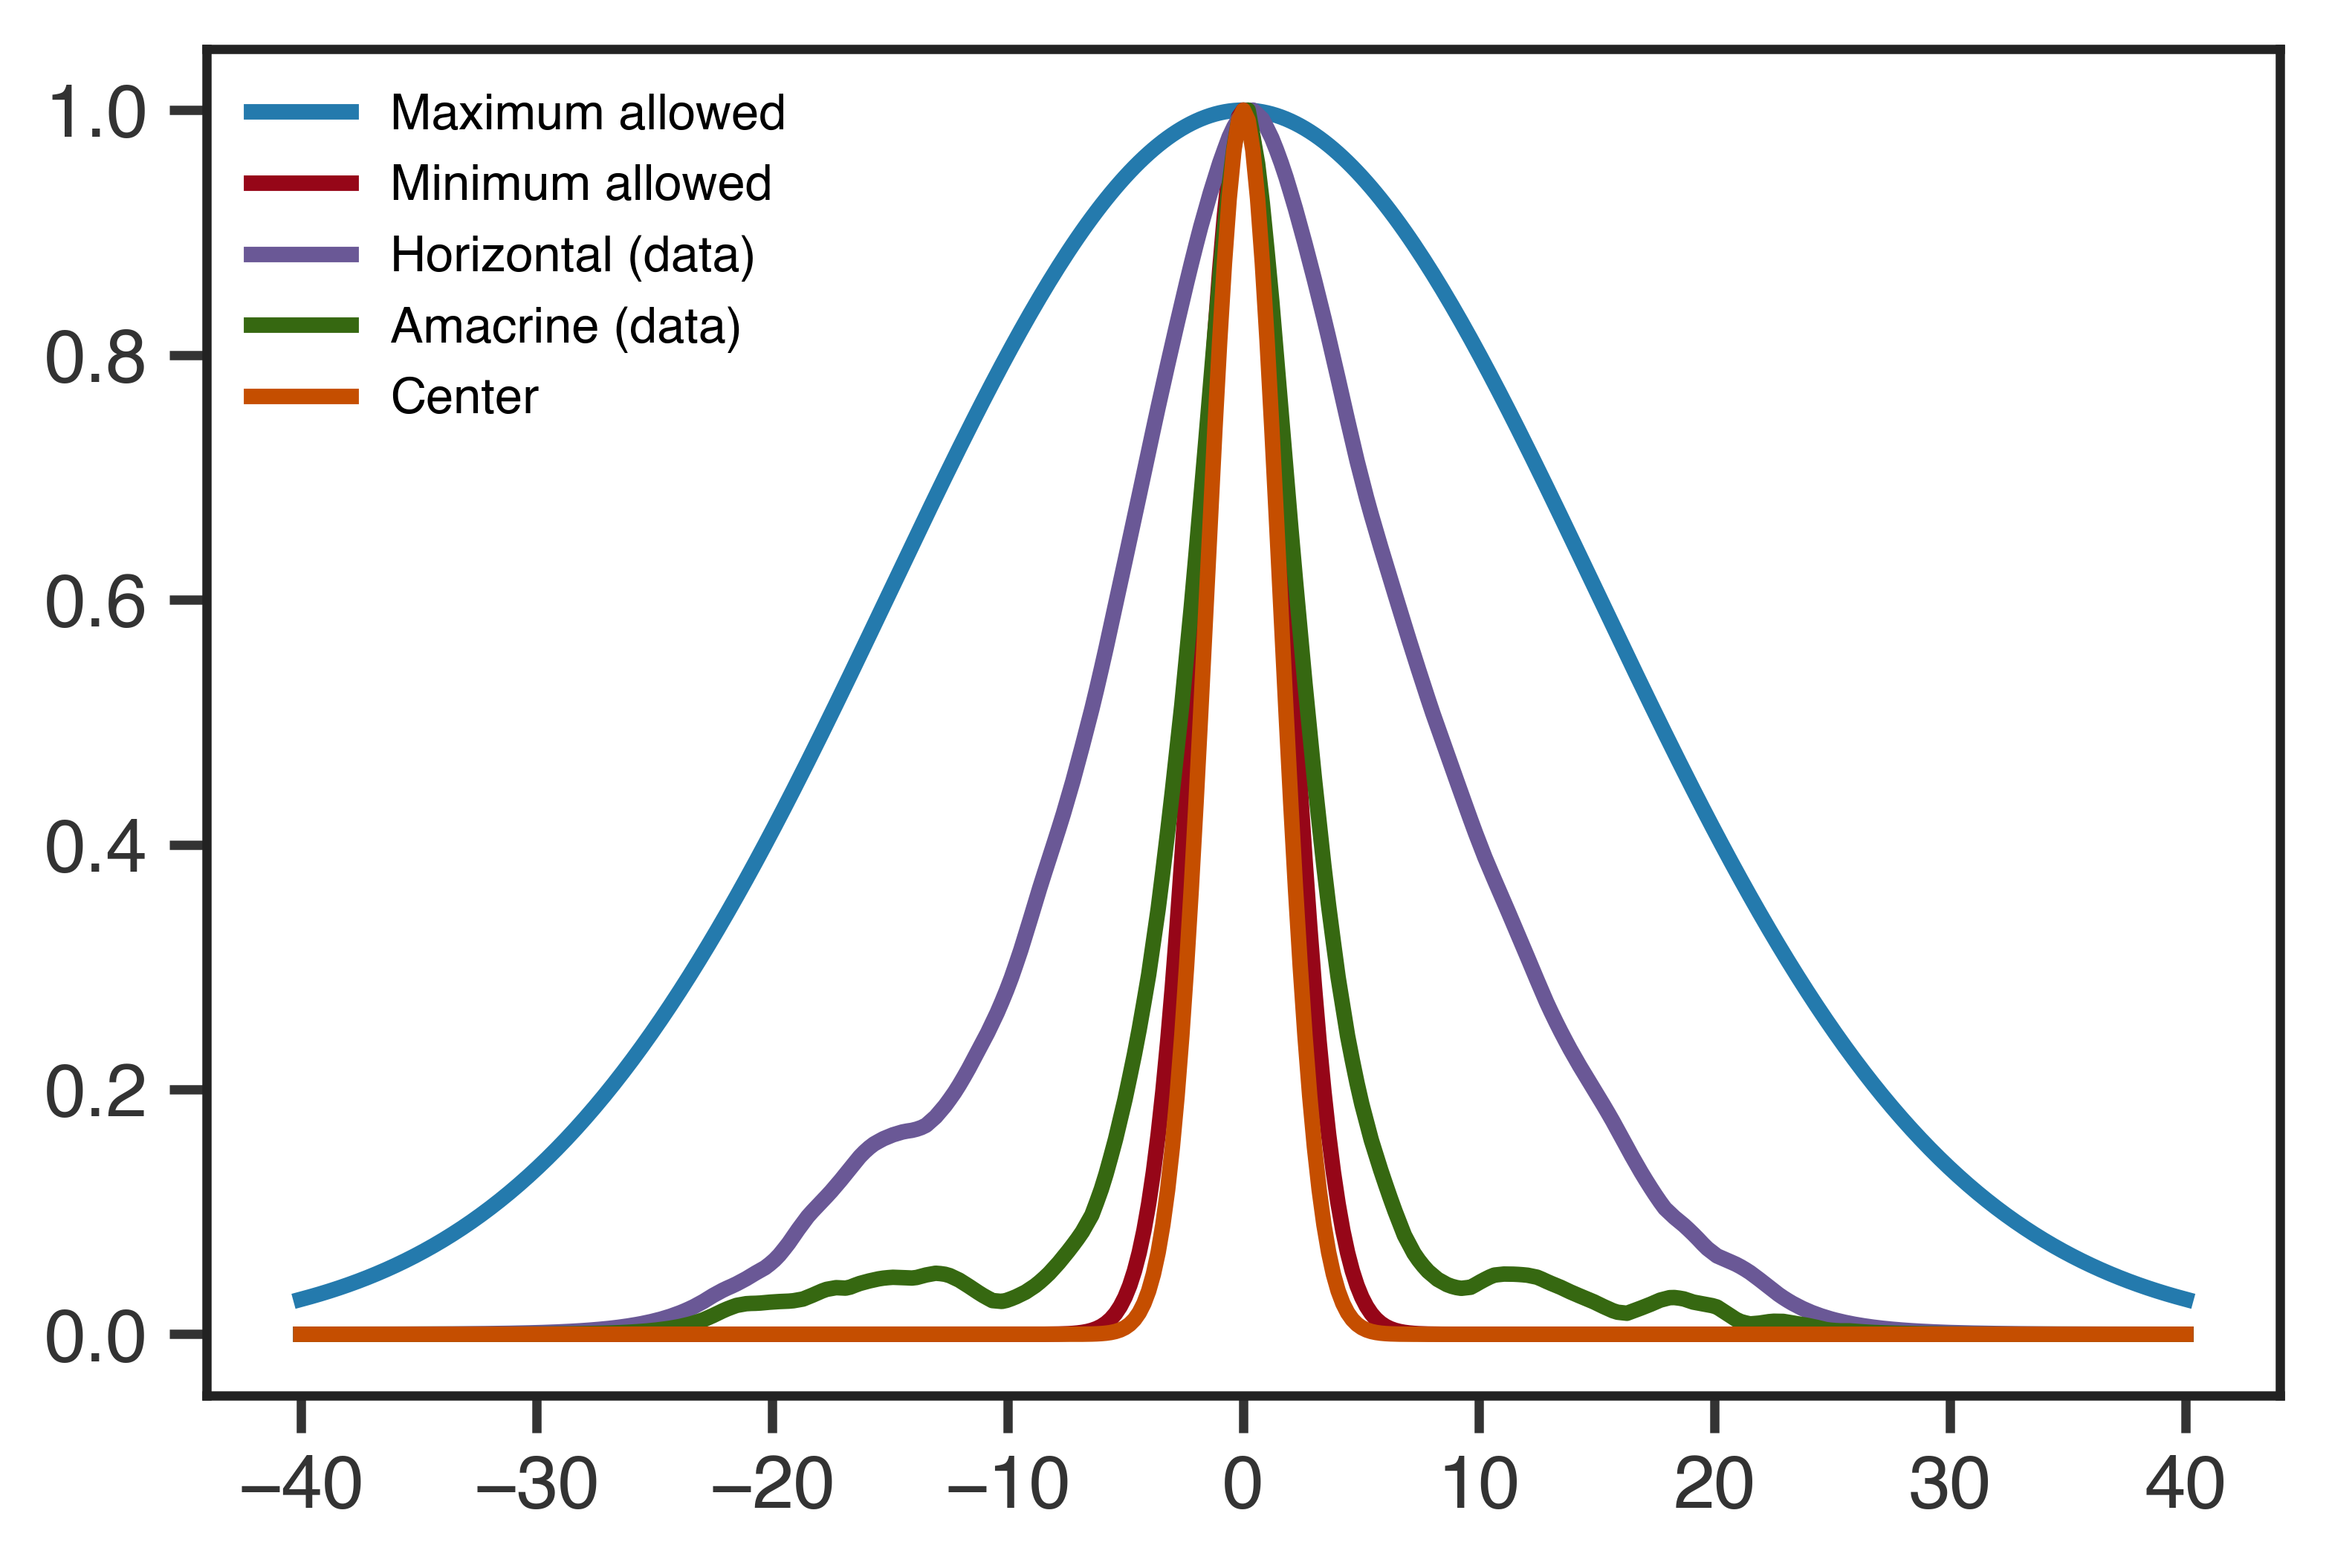

In [19]:
plt.plot(space, normalized_gaussian(x=space, sigma=15.0), label='Maximum allowed')
plt.plot(space, normalized_gaussian(x=space, sigma=1.9), label='Minimum allowed')
plt.plot(space, horz_pf/np.max(horz_pf), label='Horizontal (data)')
plt.plot(space, ama_pf/np.max(ama_pf), label='Amacrine (data)')
plt.plot(space, -center/np.max(abs(center)), label='Center')
plt.legend(frameon=False, fontsize=8, loc='upper left')

# Piece together individually run optimization scripts

In [51]:
# So far only scripts 1-6 are complete.
optimal_fun = []
optimal_filters = []
for i in range(1, 11):
    saved_dict = dd.io.load('optimization_result_{}_cell_types.h5'.format(i))
    optimal_fun.append(saved_dict['mi'])
    optimal_filters.append(saved_dict['optimal_filters'])

In [52]:
optimal_fun

[9.9446956936965698,
 16.464129302032497,
 21.402242859790977,
 18.887556385063423,
 22.133182447345618,
 23.957384738187088,
 21.847276724079251,
 23.252912895867944,
 20.411802654377798,
 20.813511895146874]

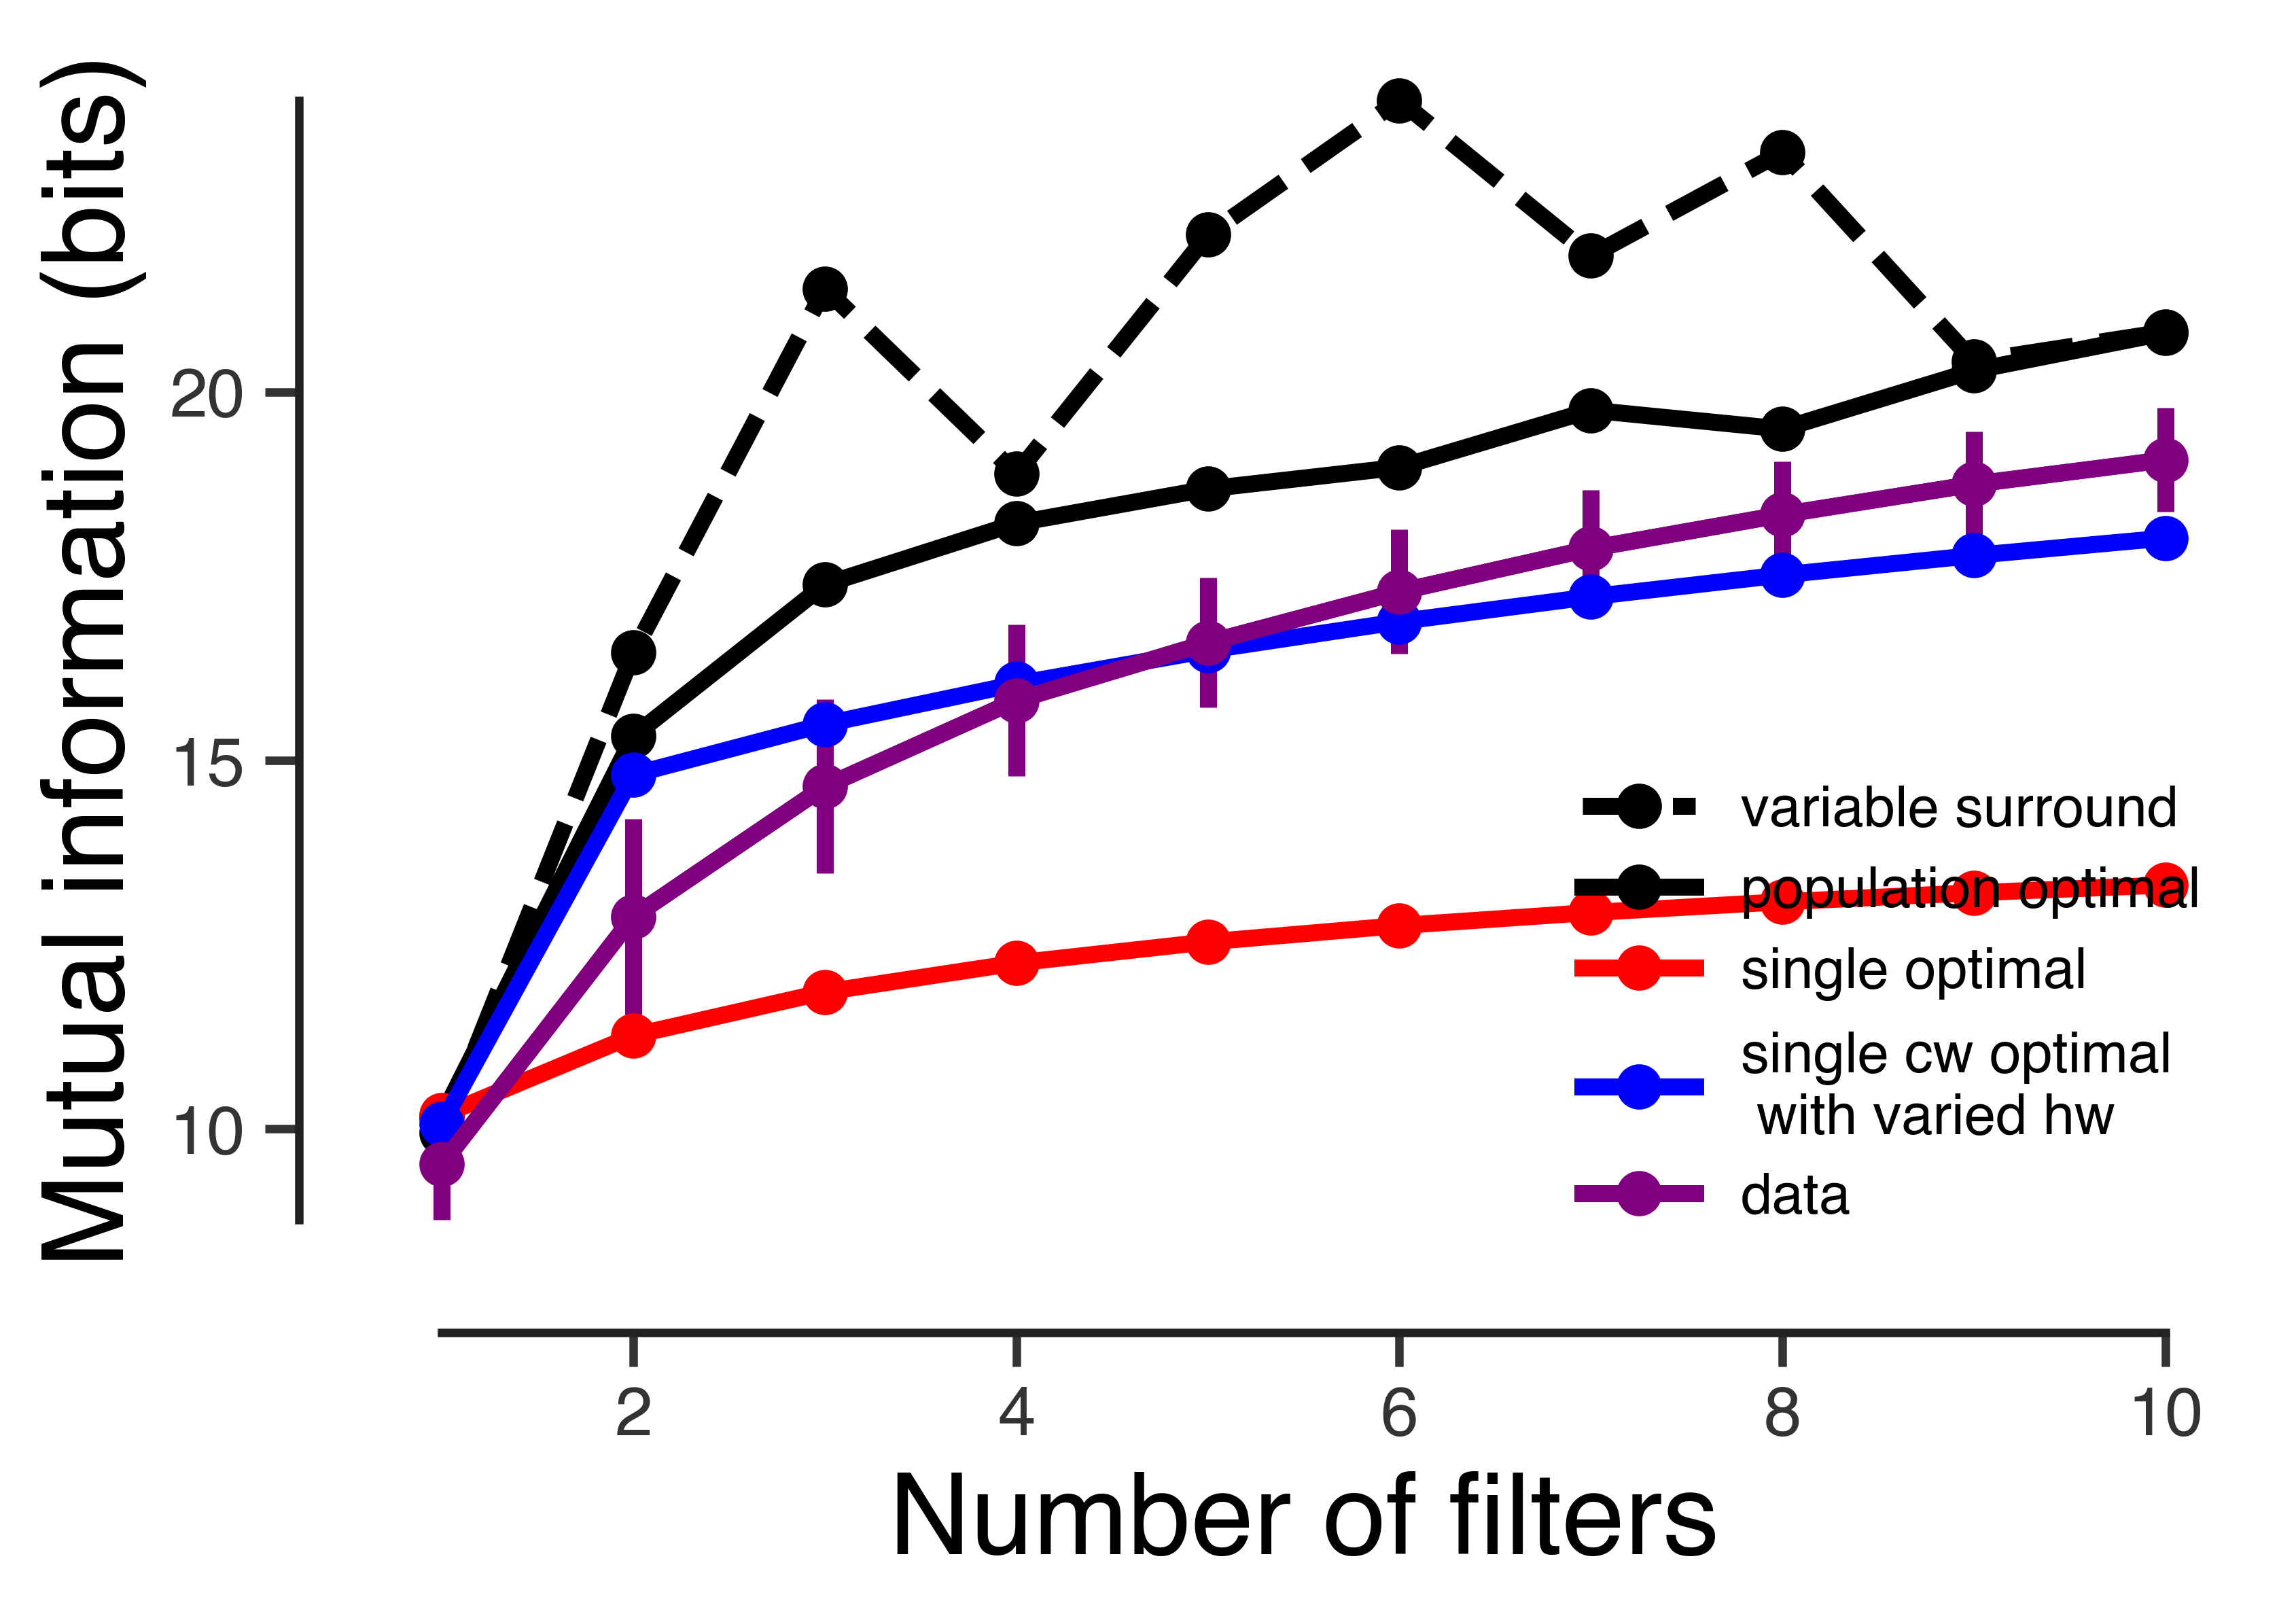

In [53]:
plt.plot(np.arange(1, len(optimal_fun) + 1), optimal_fun, 'k--', linewidth=3, marker='.',
         markersize=15, label='variable surround')
plt.plot(np.arange(1,11), info_comparison['global_opt'], 'k', linewidth=3, marker='.', 
         markersize=15, label='population optimal')
plt.plot(np.arange(1,11), info_comparison['single_cell_opt'], 'r', linewidth=3, marker='.', 
         markersize=15, label='single optimal')
plt.plot(np.arange(1,11), info_comparison['varied_hw_fixed_cw'], 'b', linewidth=3, marker='.', 
         markersize=15, label='single cw optimal \n with varied hw')
# plt.plot(np.arange(1,11), splitting_cws_fun, 'c', linewidth=3, marker='.', markersize=15)
plt.plot(np.arange(1,11), info_comparison['mean_data_info_vs_filters'], linewidth=3,
         color='purple', marker='.', markersize=15, label='data')
plt.errorbar(np.arange(1,11), info_comparison['mean_data_info_vs_filters'], 
             yerr=[np.std(data_multicell_info[i]) for i in range(1, 11)], linewidth=3, color='purple')
plt.xlabel('Number of filters', fontsize=20)
plt.ylabel('Mutual information (bits)', fontsize=20)
plt.legend(loc='lower right', frameon=False, fontsize=10)
# plt.ylim(5, 22)

majorLocator = MultipleLocator(5)
majorLocatorx = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)

ax = plt.gca()
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_major_locator(majorLocatorx)
# ax.xaxis.set_major_formatter(majorFormatter)
# ax.xaxis.set_minor_locator(minorLocator)

adjust_spines(plt.gca())

In [73]:
for filters in optimal_filters:
    print(sorted(filters[-2:]))

[1.9000133723279864, 5.8959793105793343]
[1.9112082561255734, 3.8514741575882012]
[1.8999999999999999, 5.5761436135277167]
[3.3772289747127067, 8.2793427486190883]
[2.5751998250318557, 5.0044431688662492]
[1.9766583898816648, 5.256645509291987]
[2.5948050106051697, 4.2514923780701217]
[2.5873348082235061, 4.2027396201296794]
[1.9000071192677035, 2.1056062323559566]
[1.9020456212572661, 4.8414785020571856]


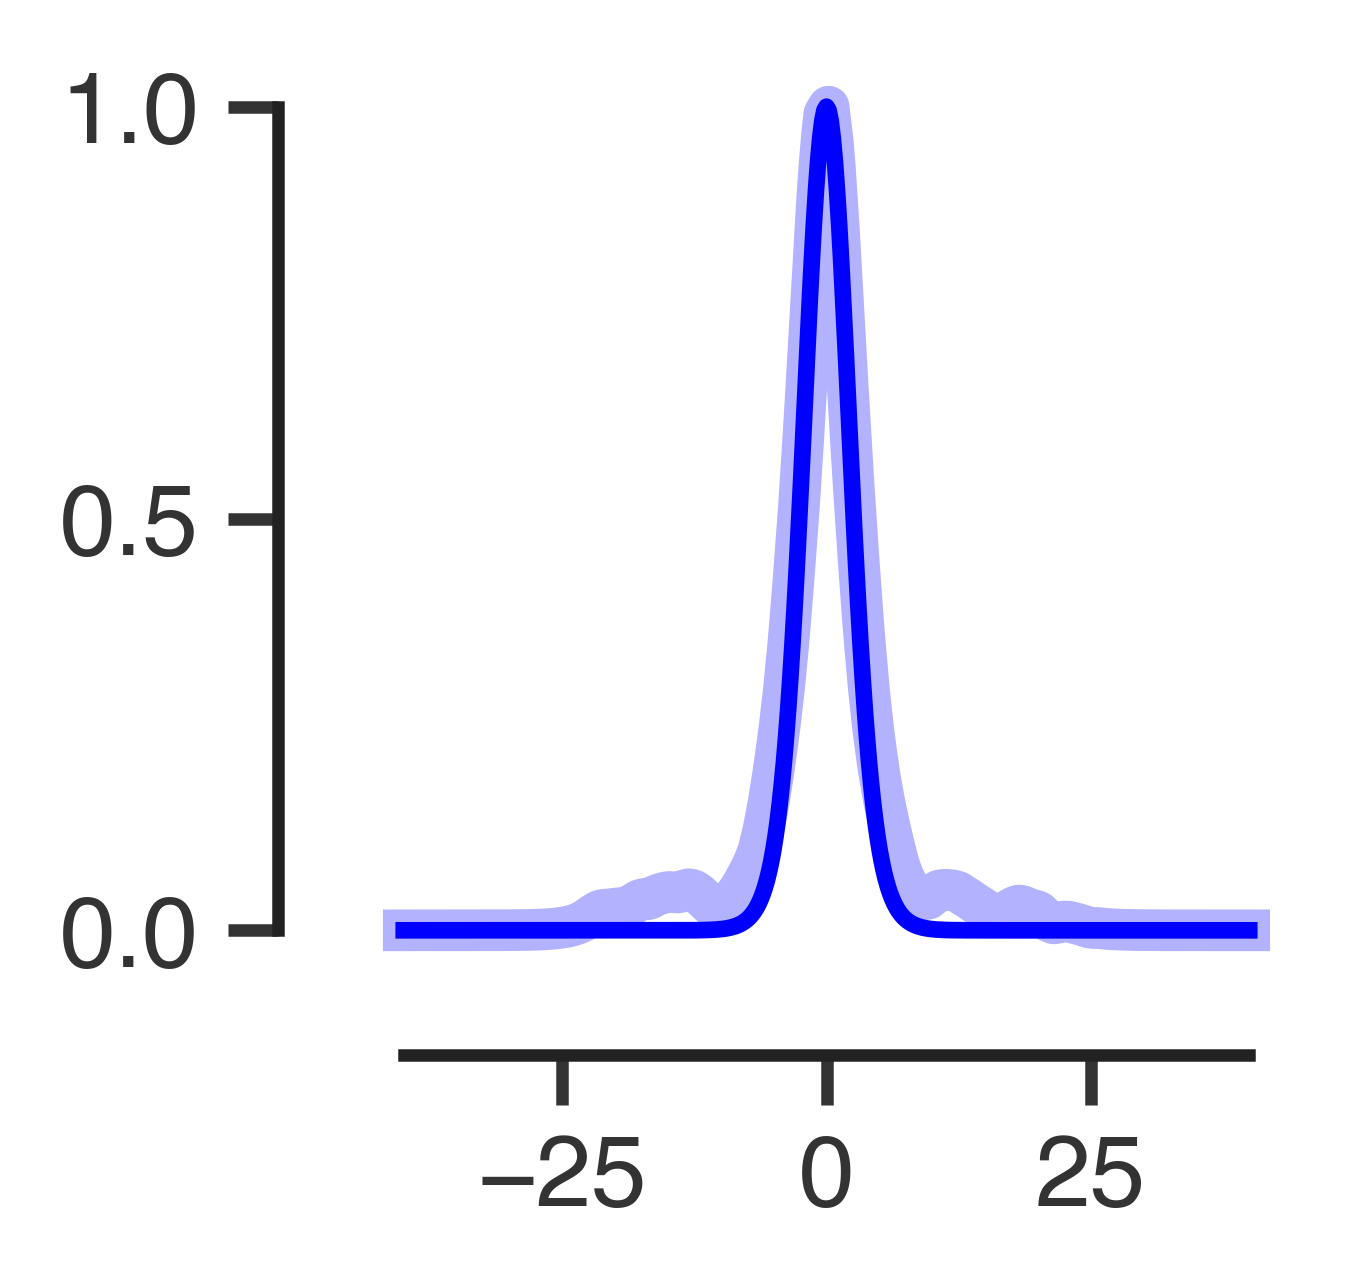

In [70]:
fig = plt.figure(figsize=(2, 2))
plt.plot(space, ama_pf/np.max(ama_pf), label='Amacrine (data)', color='#0000FF', alpha=0.3, linewidth=5)

ideal_amacrine_solutions = []
for idf, filters in enumerate(optimal_filters):
    sigma1, sigma2 = sorted(filters[-2:])
#     plt.plot(space, normalized_gaussian(x=space, sigma=sigma1), color=(1.0, idf / 15.0, 0))
#     plt.plot(space, normalized_gaussian(x=space, sigma=sigma1), color='#0000FF', linewidth=2)
    ideal_amacrine_solutions.append(normalized_gaussian(x=space, sigma=sigma1))

# plt.errorbar(space, np.mean(np.stack(ideal_amacrine_solutions), axis=0), 
#              yerr=np.std(np.stack(ideal_amacrine_solutions), axis=0), color='k', alpha=0.1,
#              linewidth=1)
plt.plot(space, np.mean(np.stack(ideal_amacrine_solutions), axis=0), color='#0000FF', linewidth=2)


# plt.plot(space, horz_pf/np.max(horz_pf), label='Horizontal (data)')
# plt.plot(space, -center/np.max(abs(center)), label='Center')
# plt.legend(frameon=False, fontsize=8, loc='upper left')
adjust_spines(plt.gca())

In [77]:
np.mean(sem(np.stack(ideal_amacrine_solutions), axis=0))

0.0050790708981746585

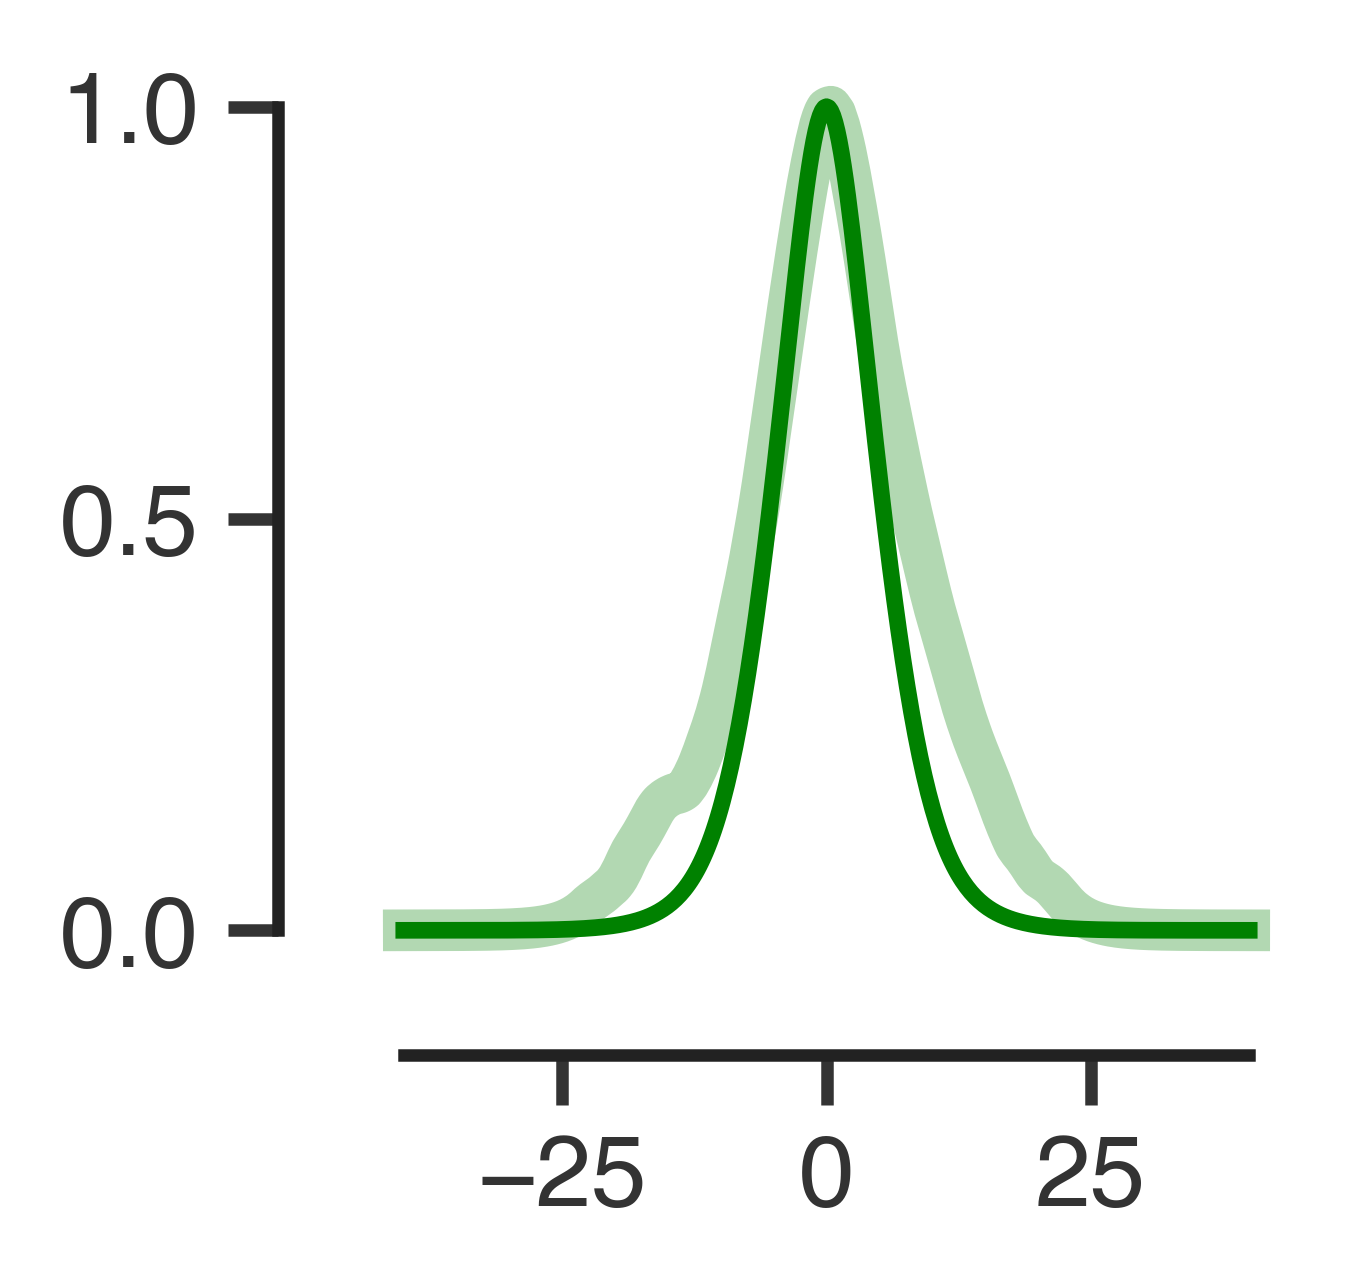

In [74]:
fig = plt.figure(figsize=(2, 2))
plt.plot(space, horz_pf/np.max(horz_pf), label='Horizontal (data)', color='#008100', alpha=0.3, linewidth=5)

ideal_horizontal_solutions = []
for idf, filters in enumerate(optimal_filters):
    sigma1, sigma2 = sorted(filters[-2:])
#     plt.plot(space, normalized_gaussian(x=space, sigma=sigma2), color='#008100', linewidth=2)
    ideal_horizontal_solutions.append(normalized_gaussian(x=space, sigma=sigma2))

# plt.errorbar(space, np.mean(np.stack(ideal_horizontal_solutions), axis=0), 
#              yerr=np.std(np.stack(ideal_horizontal_solutions), axis=0), color='k', alpha=0.1,
#              linewidth=1)
plt.plot(space, np.mean(np.stack(ideal_horizontal_solutions), axis=0), color='#008100', linewidth=2)


adjust_spines(plt.gca())

In [78]:
np.mean(sem(np.stack(ideal_horizontal_solutions), axis=0))

0.017236292874894962

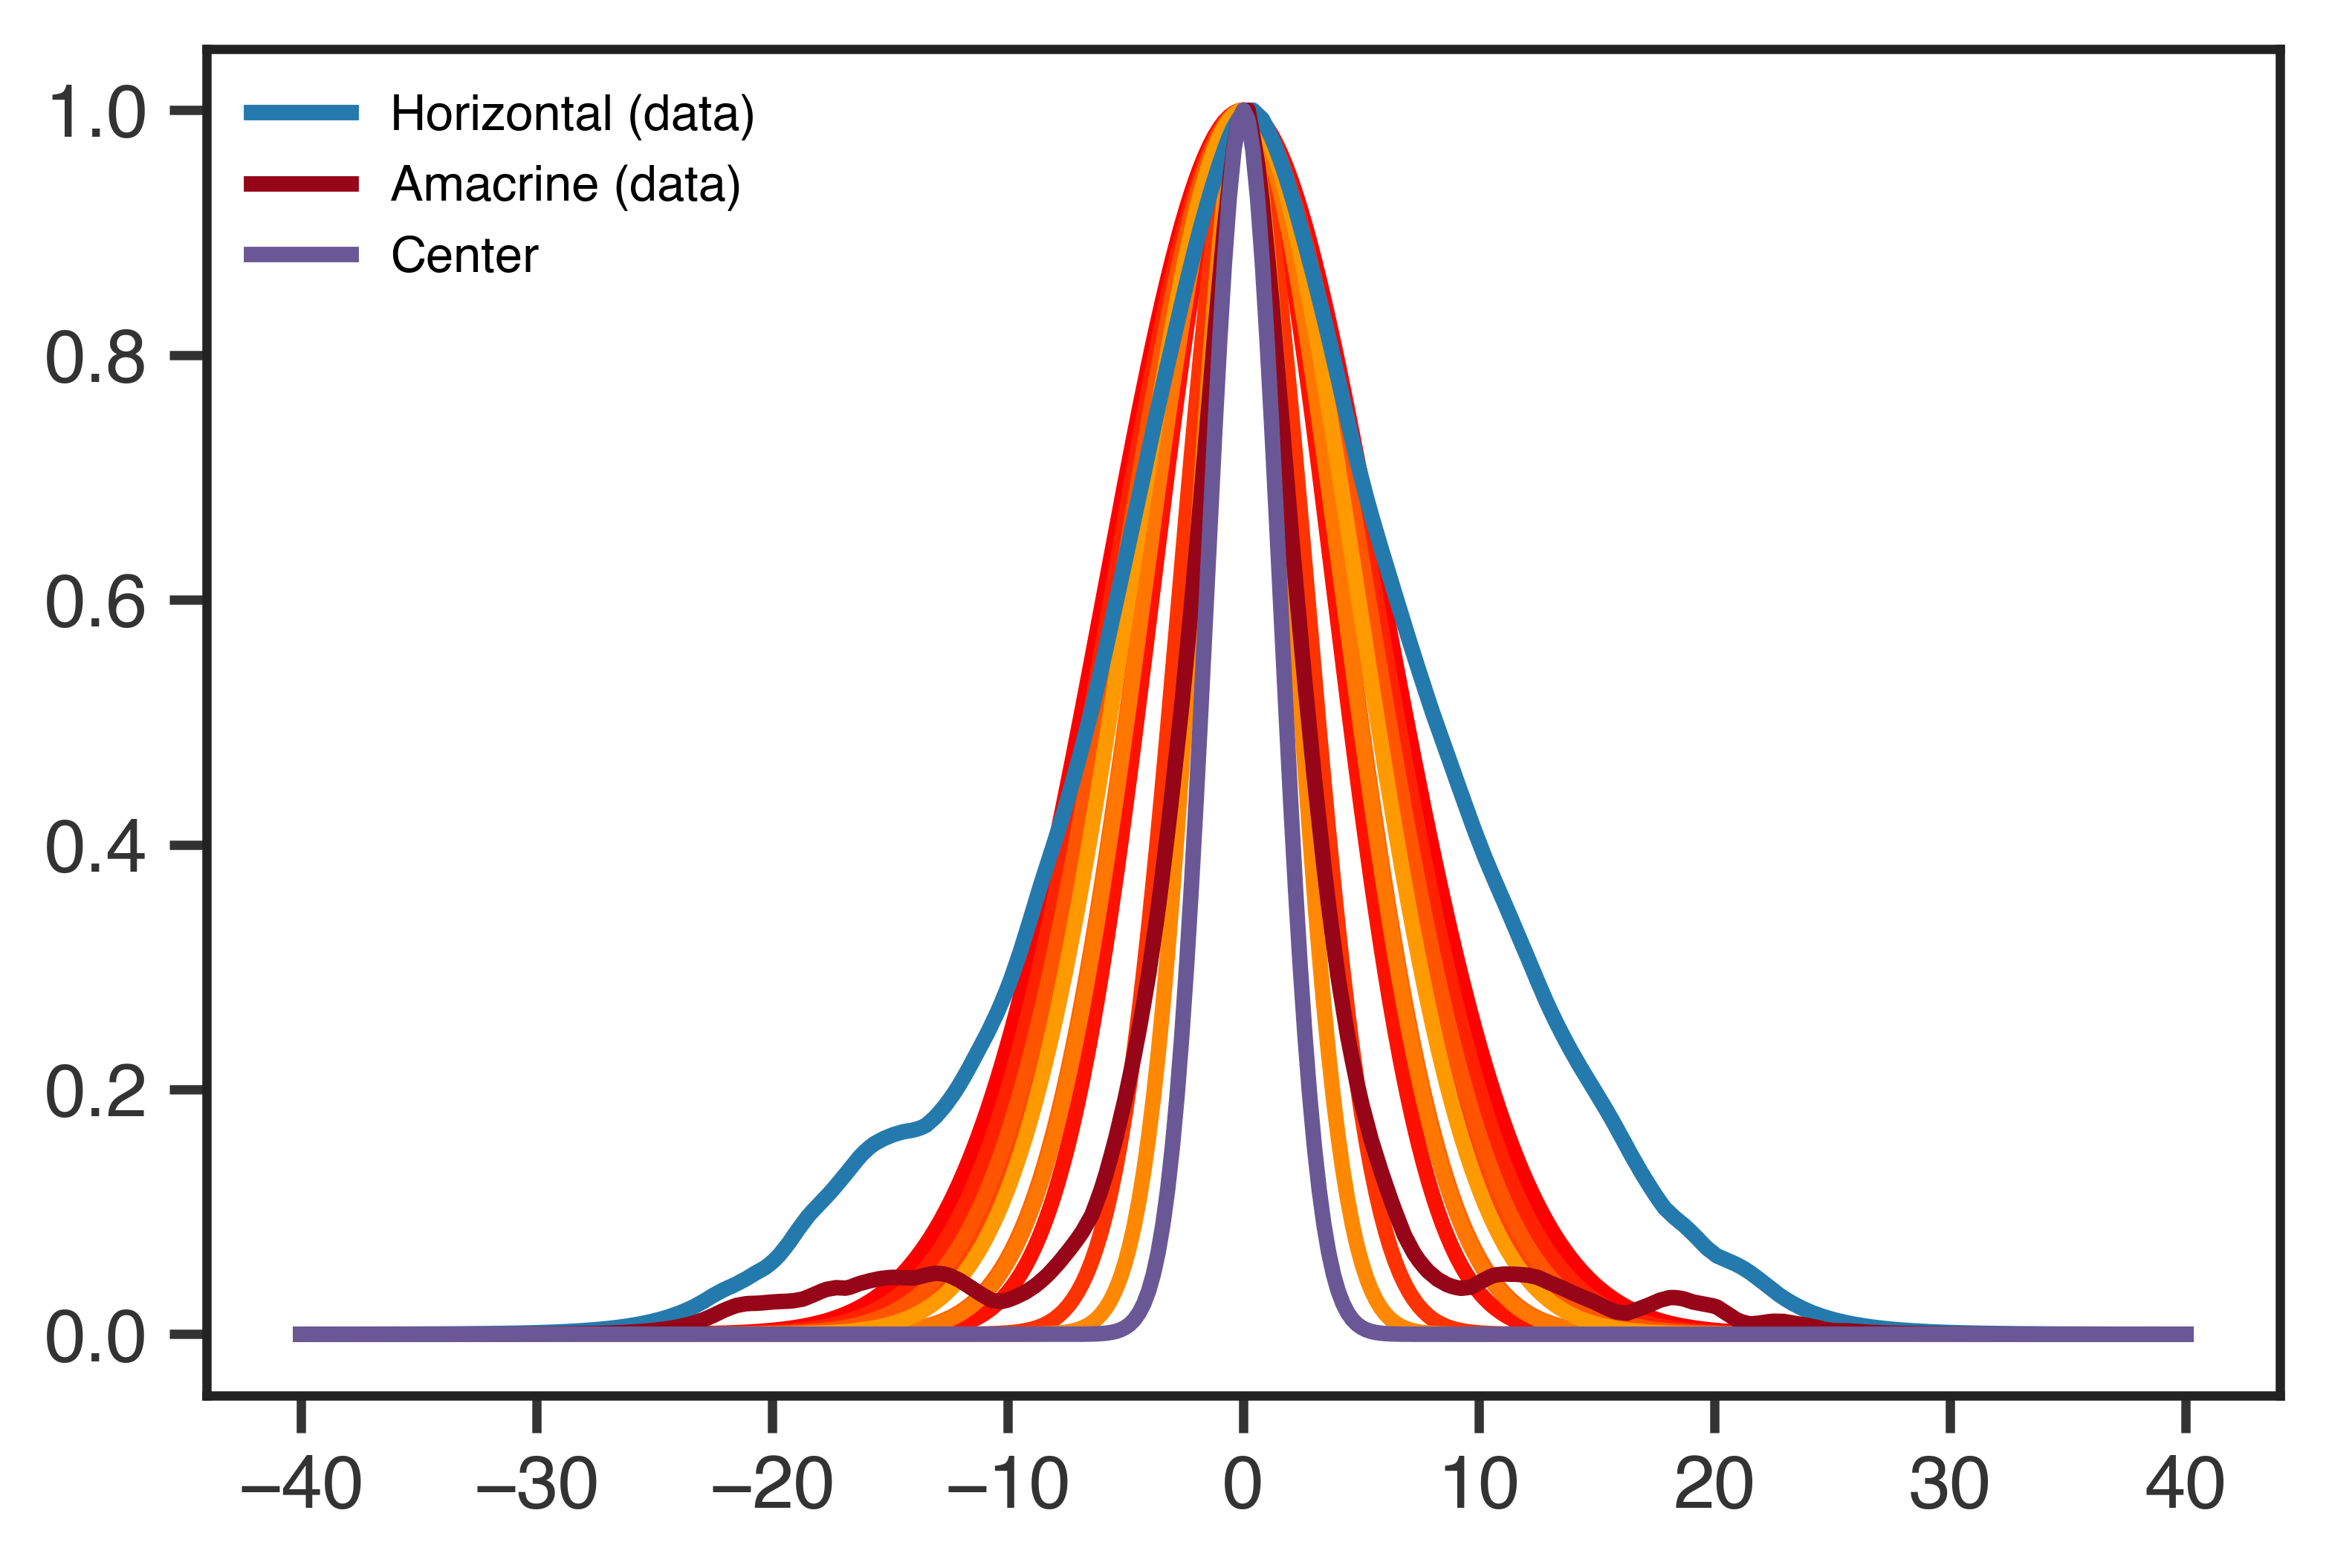

In [50]:
for idf, filters in enumerate(optimal_filters):
    sigma1, sigma2 = sorted(filters[-2:])
    plt.plot(space, normalized_gaussian(x=space, sigma=sigma2), color=(1.0, idf / 15.0, 0))
plt.plot(space, horz_pf/np.max(horz_pf), label='Horizontal (data)')
plt.plot(space, ama_pf/np.max(ama_pf), label='Amacrine (data)')
plt.plot(space, -center/np.max(abs(center)), label='Center')
plt.legend(frameon=False, fontsize=8, loc='upper left')

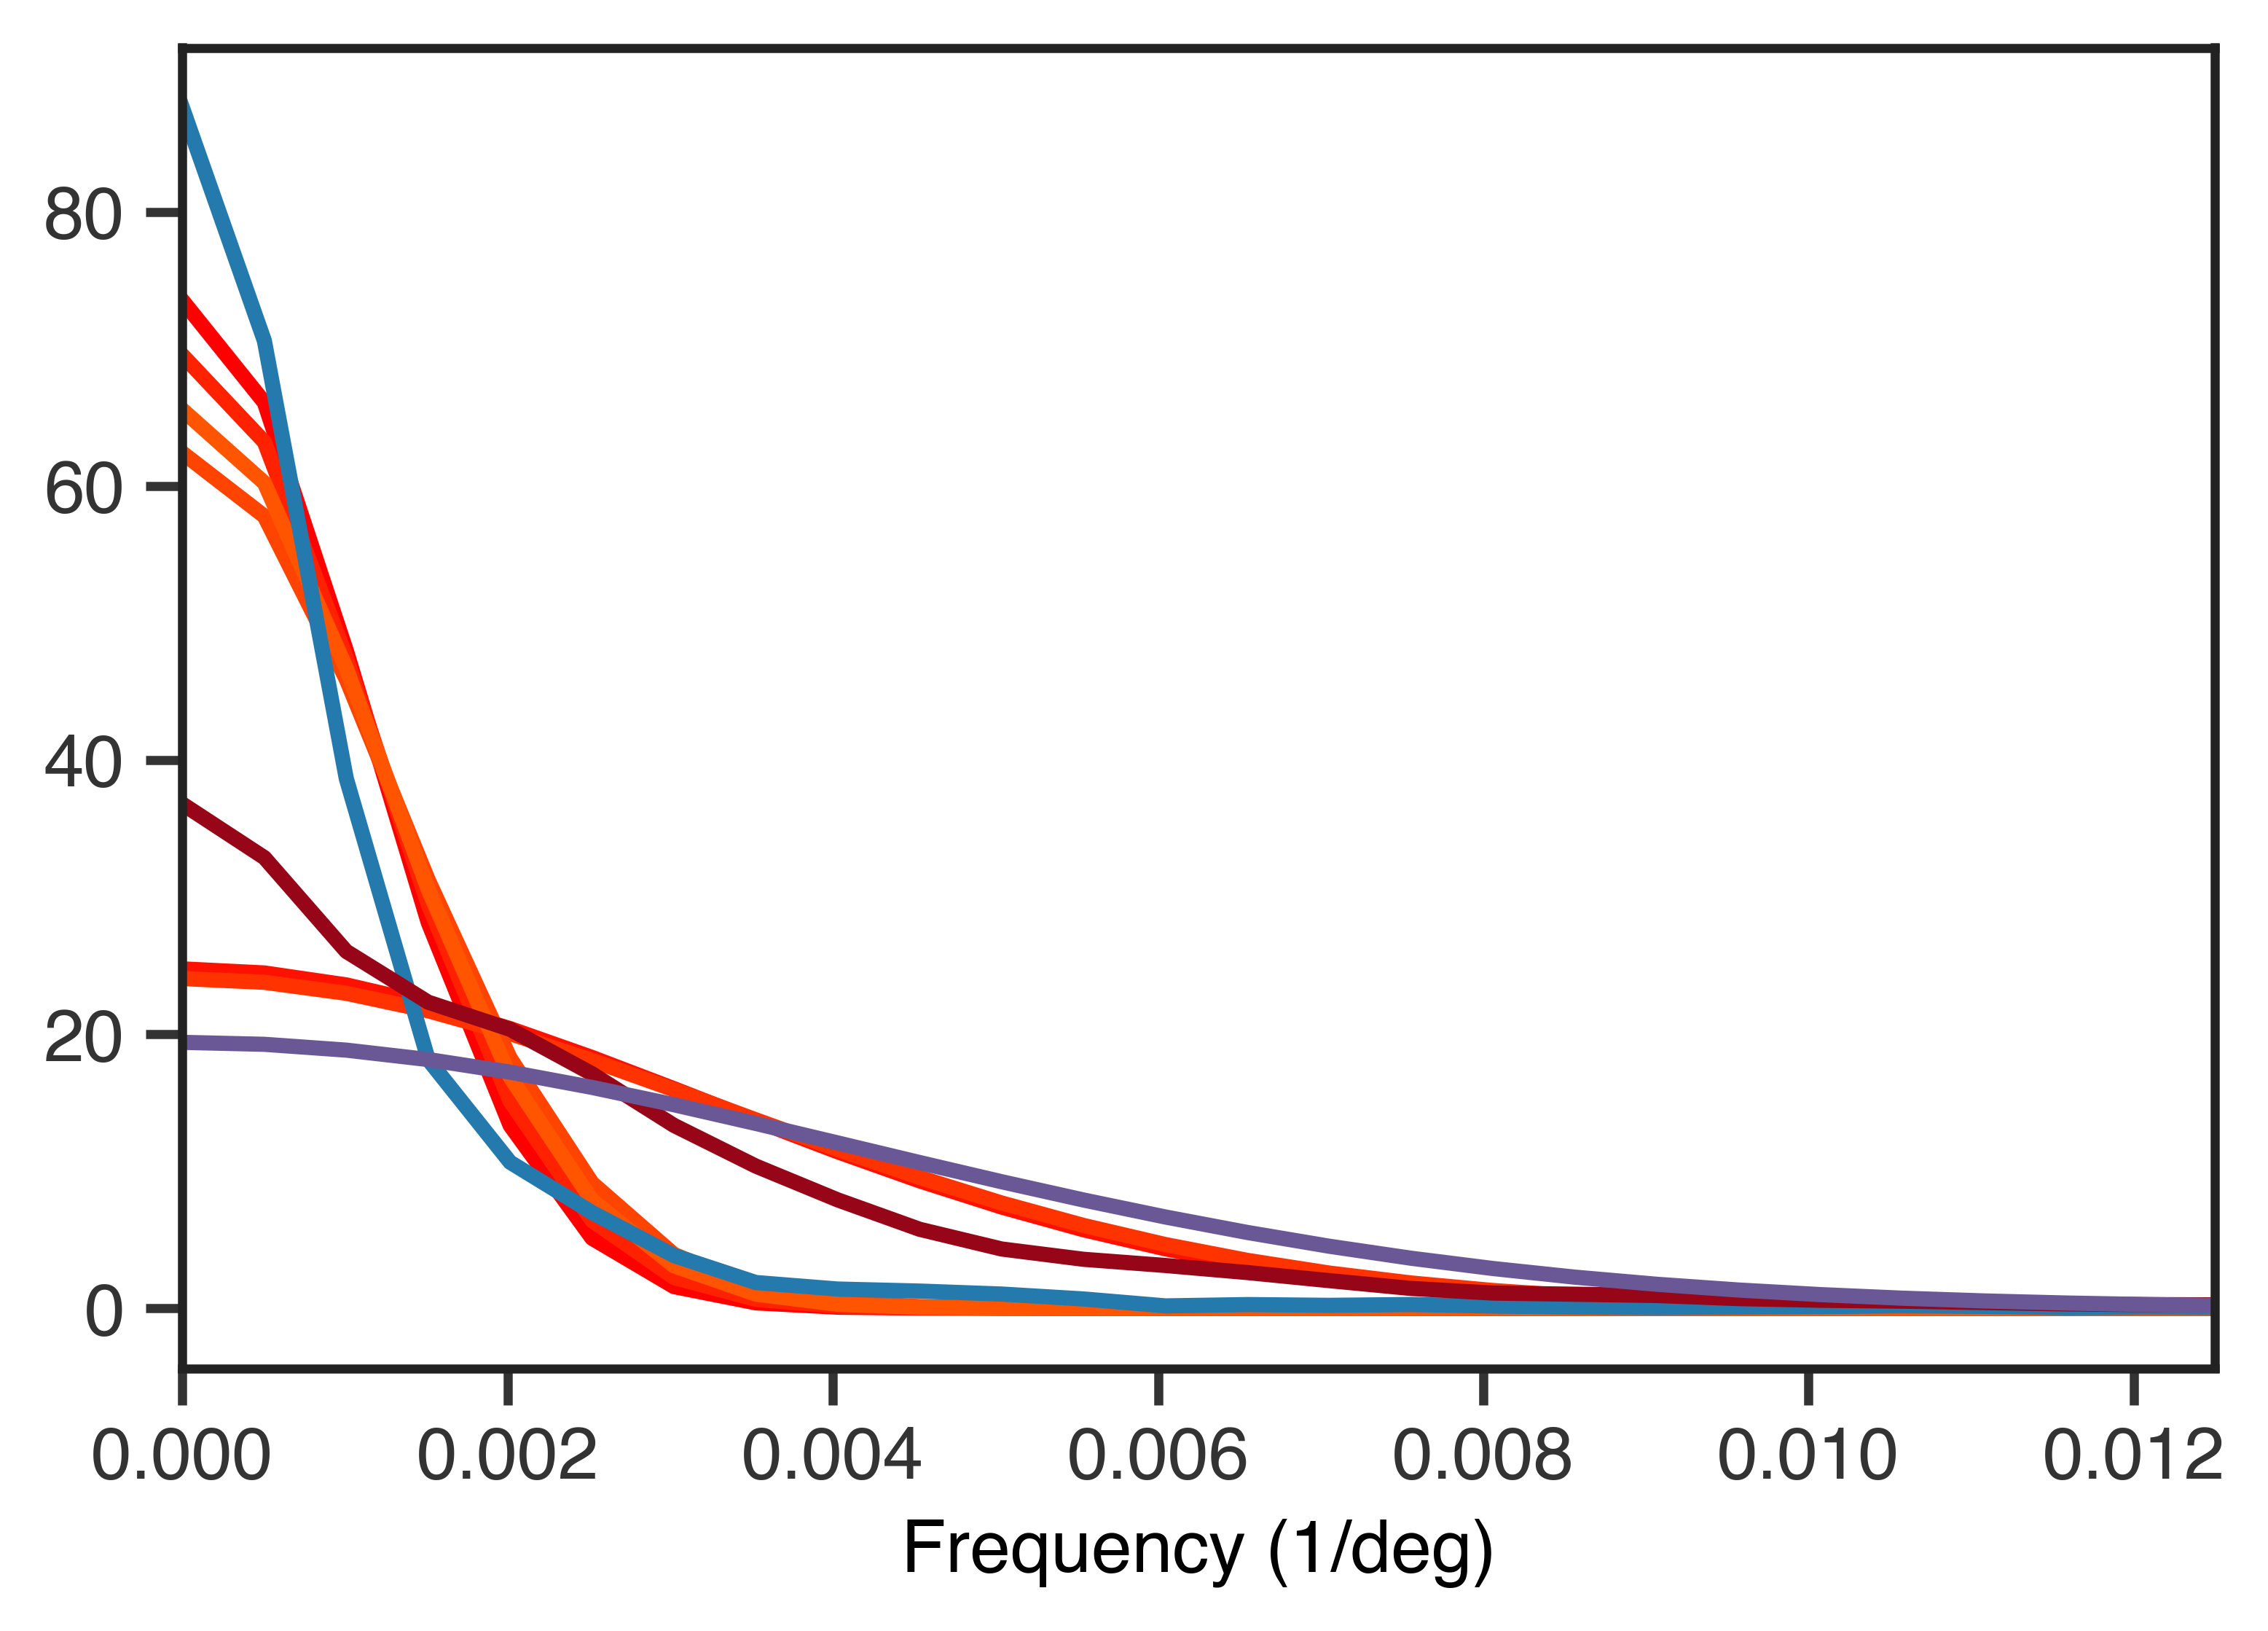

In [44]:
ffts = []
freqs = []
for idf, filters in enumerate(optimal_filters):
    sigma1, sigma2 = sorted(filters[-2:])
    ffts.append(np.fft.rfft(normalized_gaussian(x=space, sigma=sigma2)))
    freqs.append(np.fft.rfftfreq(len(space), d=1./np.mean(np.diff(space))))
    plt.plot(freqs[-1], abs(ffts[-1]), color=(1.0, idf / 15.0, 0))
    
    
plt.plot(freqs[-1], abs(np.fft.rfft(horz_pf/np.max(horz_pf))), label='Horizontal (data)')
plt.plot(freqs[-1], abs(np.fft.rfft(ama_pf/np.max(ama_pf))), label='Amacrine (data)')
plt.plot(freqs[-1], abs(np.fft.rfft(-center/np.max(abs(center)))), label='Center')

plt.xlim(0, 0.0125)
plt.xlabel('Frequency (1/deg)')

# 1 Filter

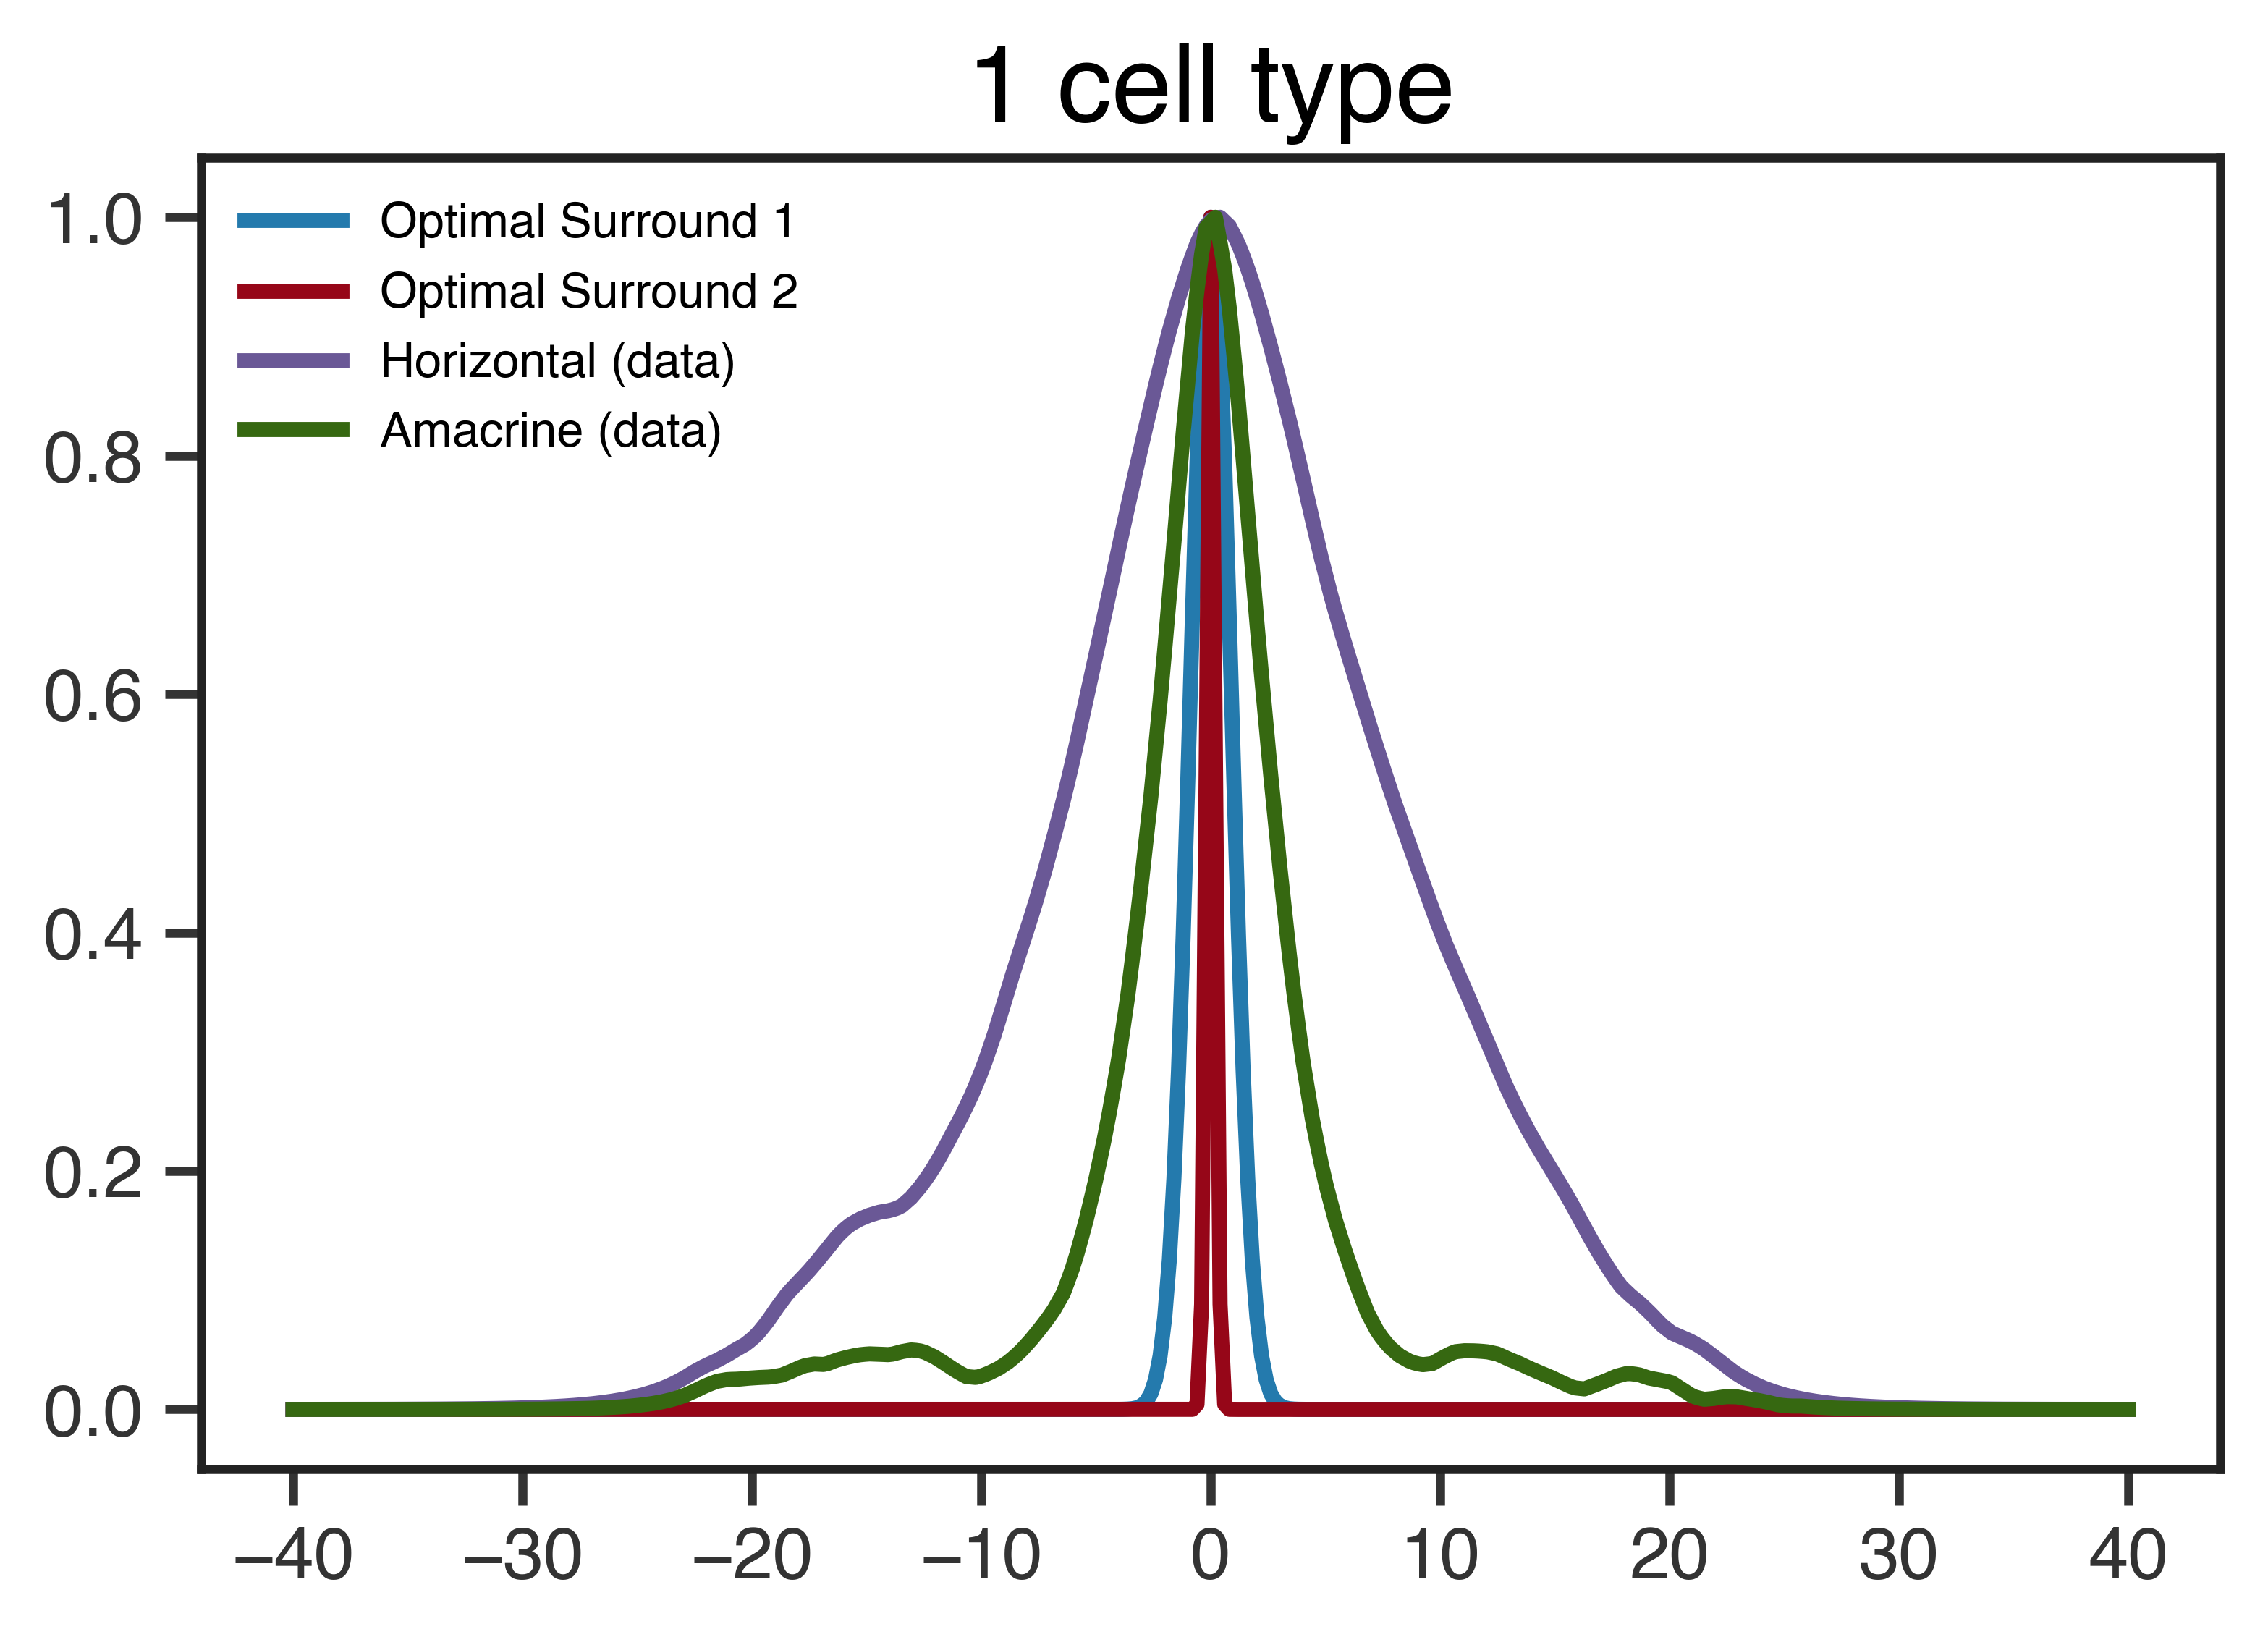

In [106]:
plt.plot(space, normalized_gaussian(x=space, sigma=optimal_filters[0][-1]), label='Optimal Surround 1')
plt.plot(space, normalized_gaussian(x=space, sigma=optimal_filters[0][-2]), label='Optimal Surround 2')
plt.plot(space, horz_pf/np.max(horz_pf), label='Horizontal (data)')
plt.plot(space, ama_pf/np.max(ama_pf), label='Amacrine (data)')
plt.legend(frameon=False, fontsize=8, loc='upper left')
plt.title('1 cell type', fontsize=18)

# 5 Filters

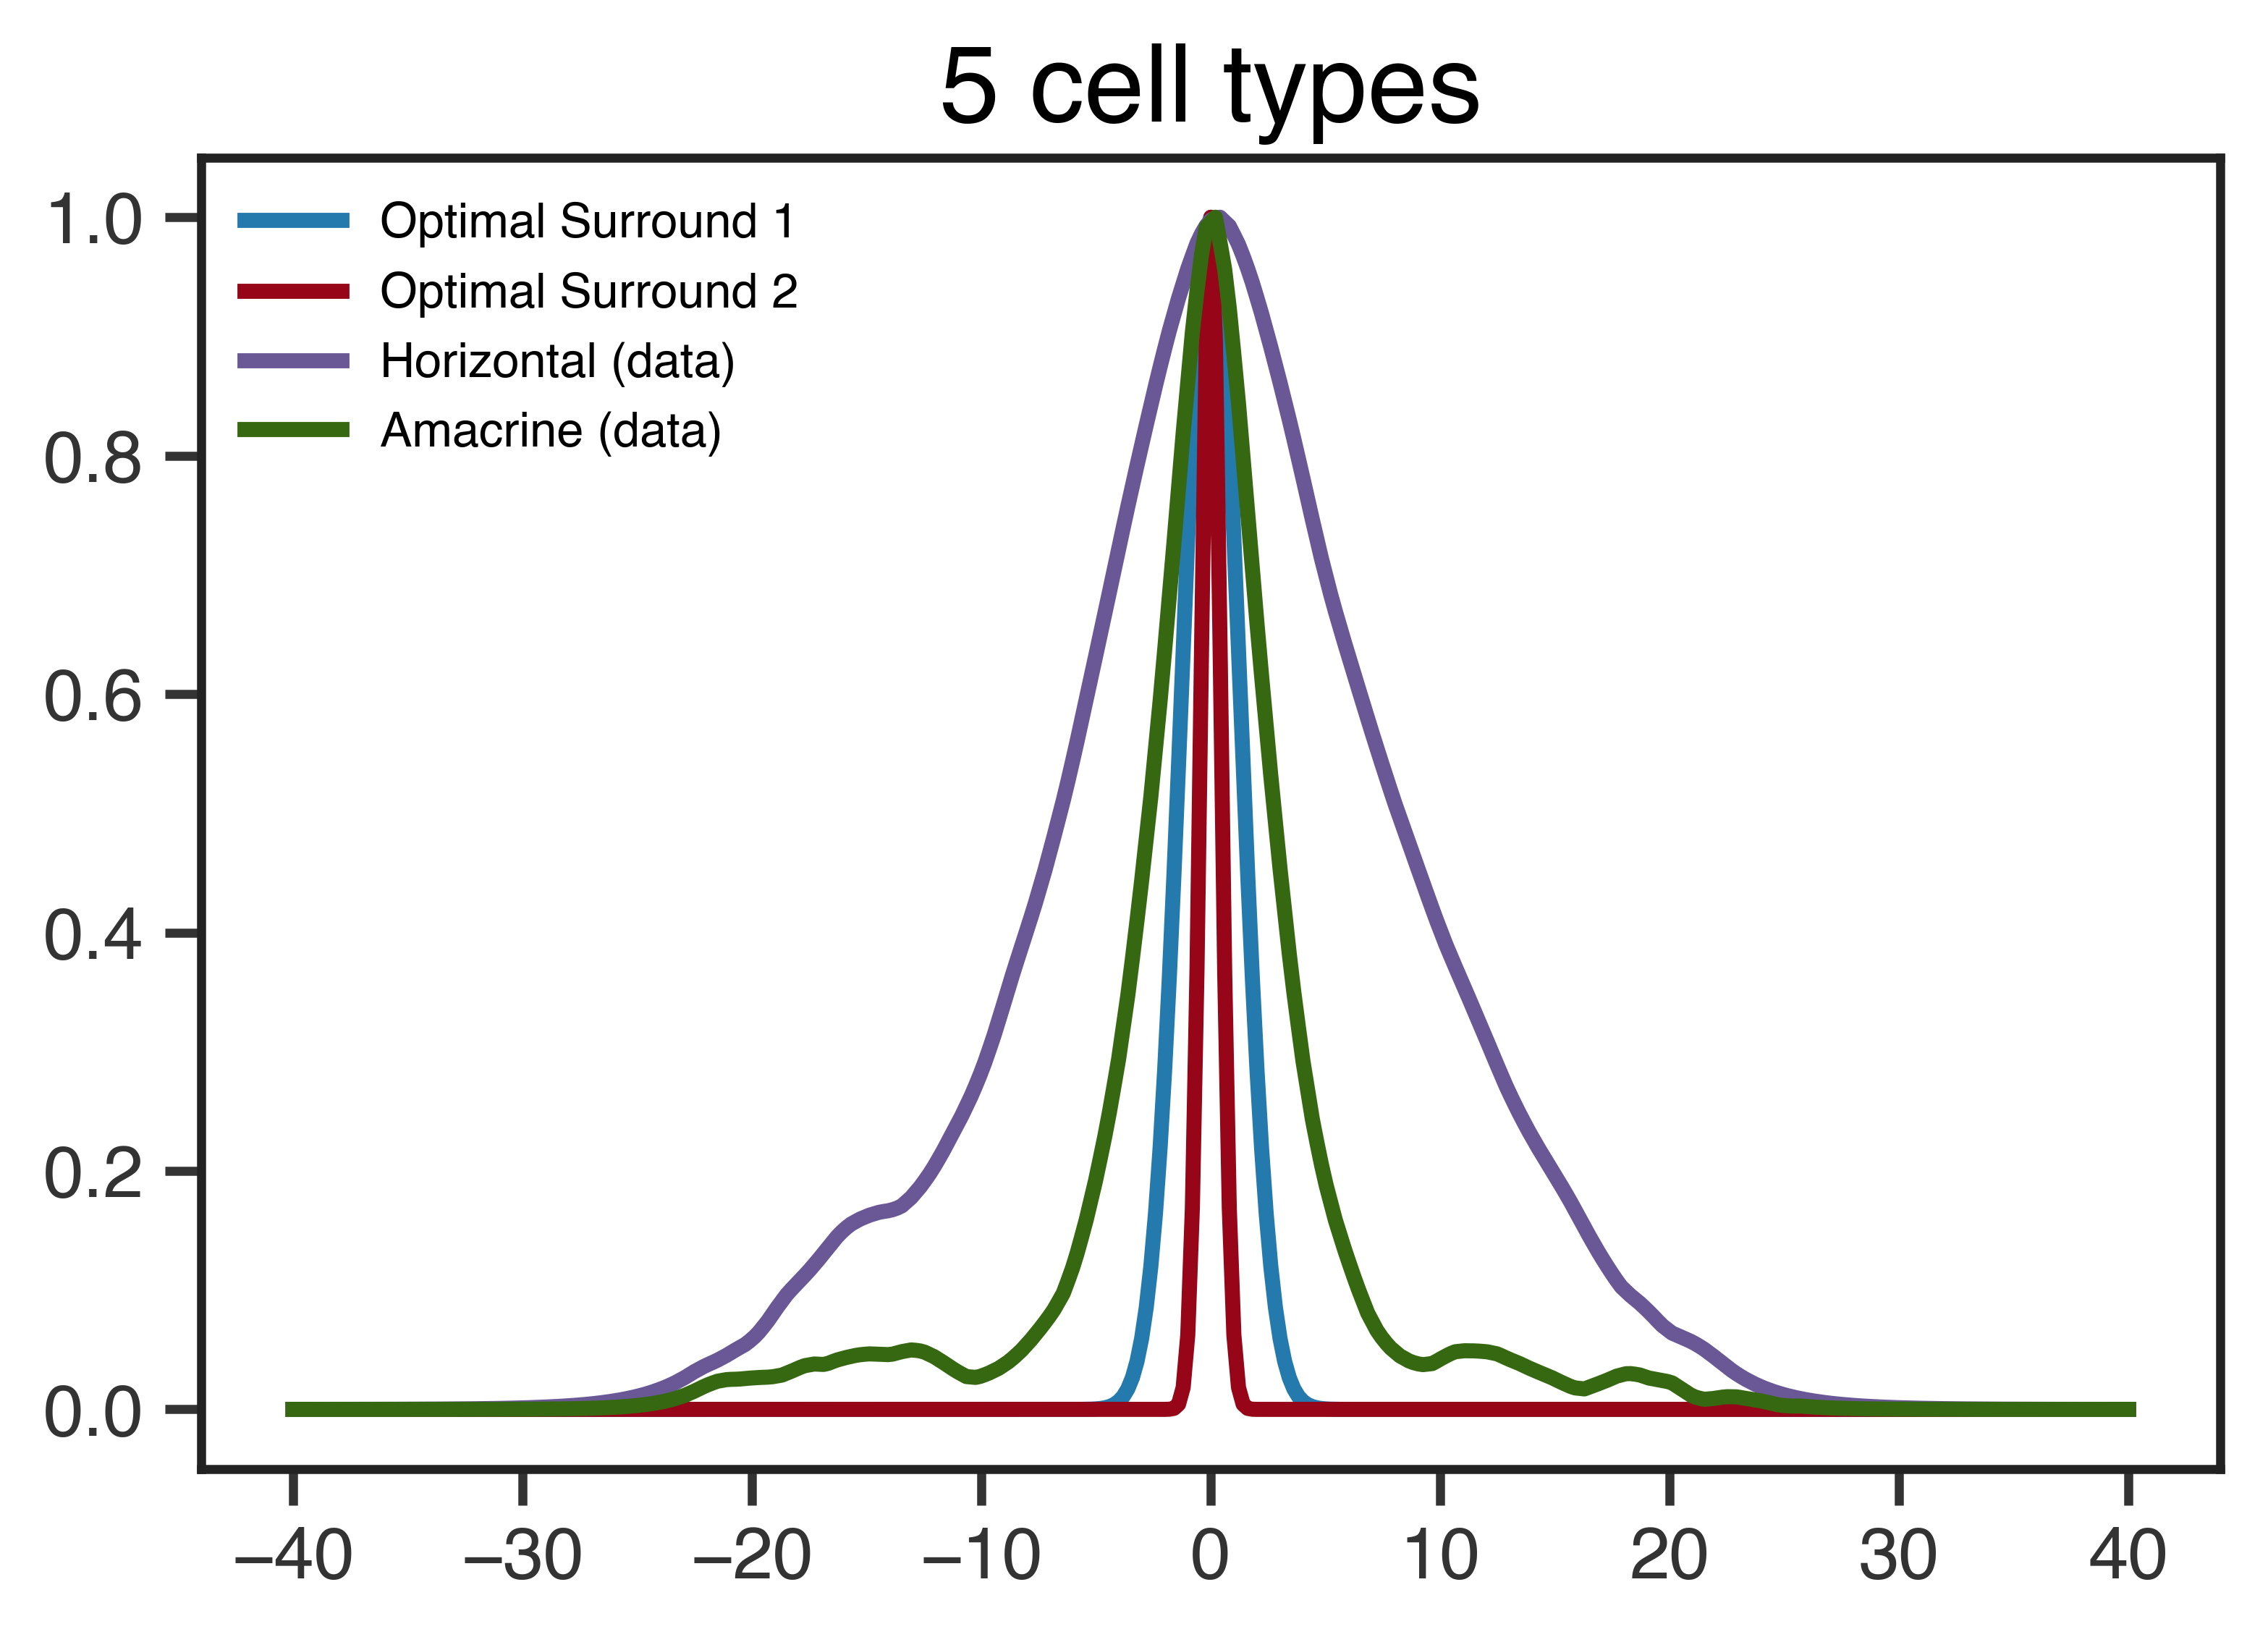

In [105]:
plt.plot(space, normalized_gaussian(x=space, sigma=optimal_filters[4][-1]), label='Optimal Surround 1')
plt.plot(space, normalized_gaussian(x=space, sigma=optimal_filters[4][-2]), label='Optimal Surround 2')
plt.plot(space, horz_pf/np.max(horz_pf), label='Horizontal (data)')
plt.plot(space, ama_pf/np.max(ama_pf), label='Amacrine (data)')
plt.legend(frameon=False, fontsize=8, loc='upper left')
plt.title('5 cell types', fontsize=18)

# 10 Filters

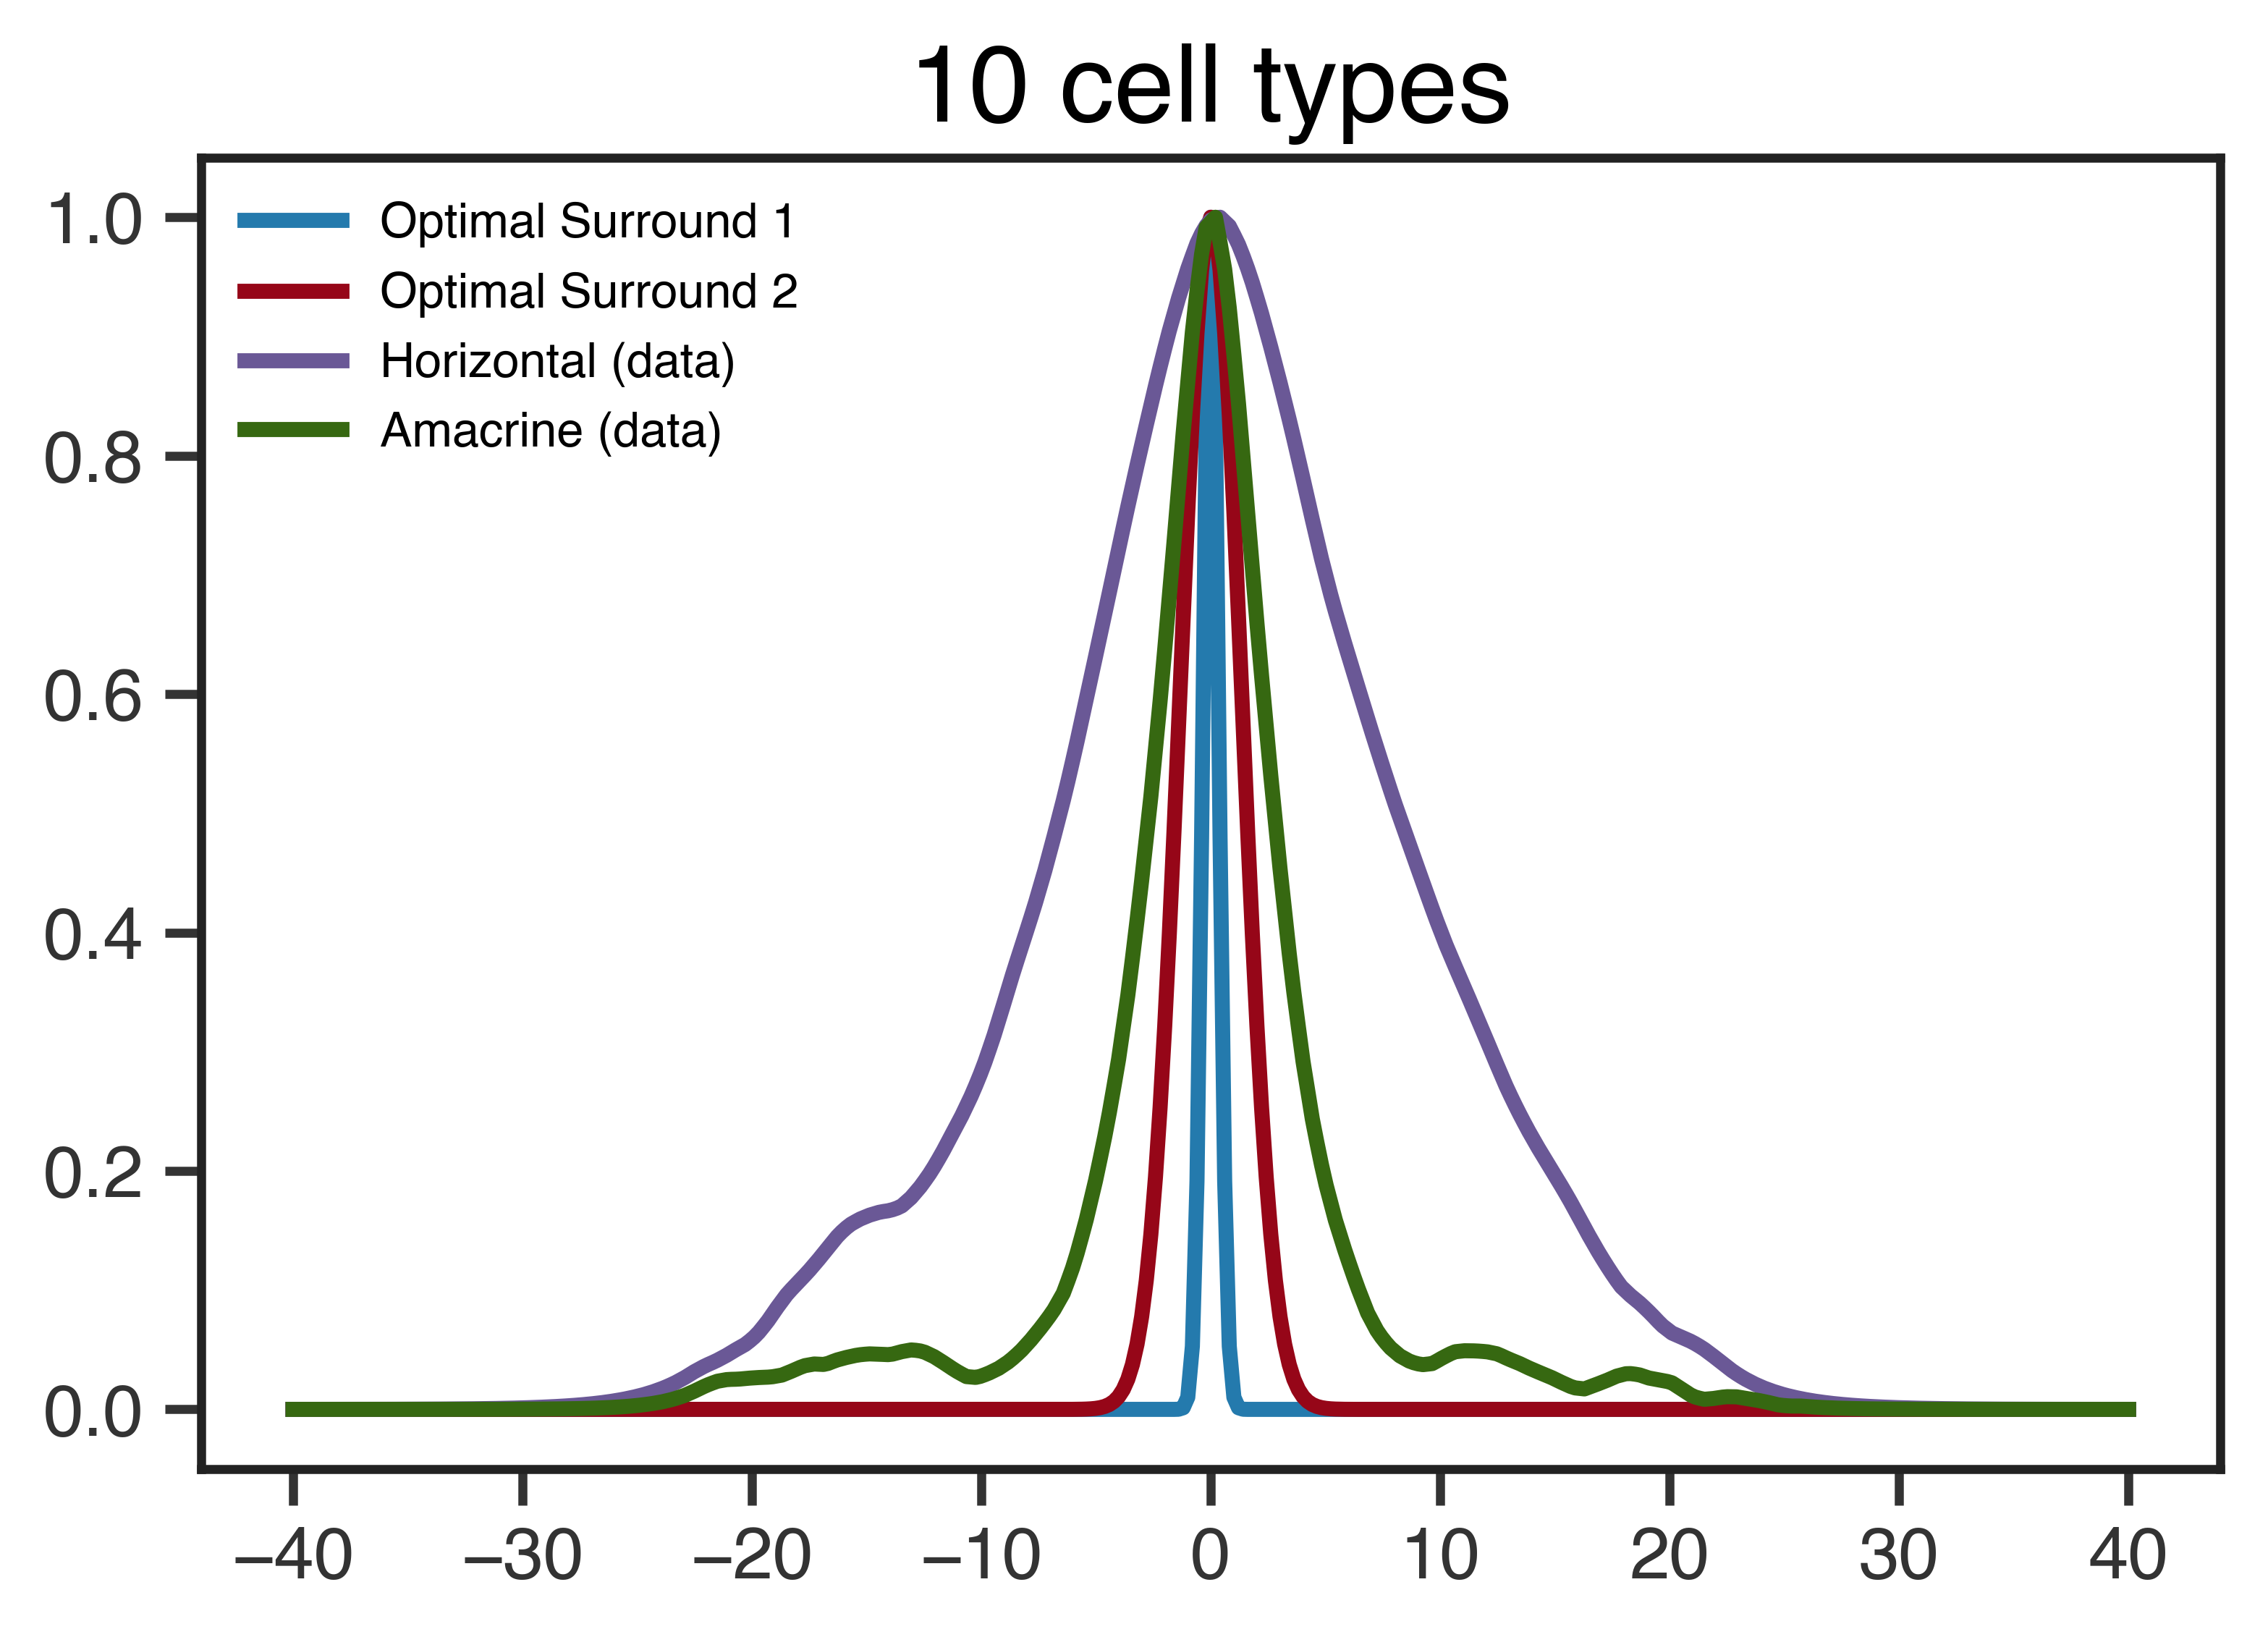

In [104]:
plt.plot(space, normalized_gaussian(x=space, sigma=optimal_filters[9][-1]), label='Optimal Surround 1')
plt.plot(space, normalized_gaussian(x=space, sigma=optimal_filters[9][-2]), label='Optimal Surround 2')
plt.plot(space, horz_pf/np.max(horz_pf), label='Horizontal (data)')
plt.plot(space, ama_pf/np.max(ama_pf), label='Amacrine (data)')
plt.legend(frameon=False, fontsize=8, loc='upper left')
plt.title('10 cell types', fontsize=18)

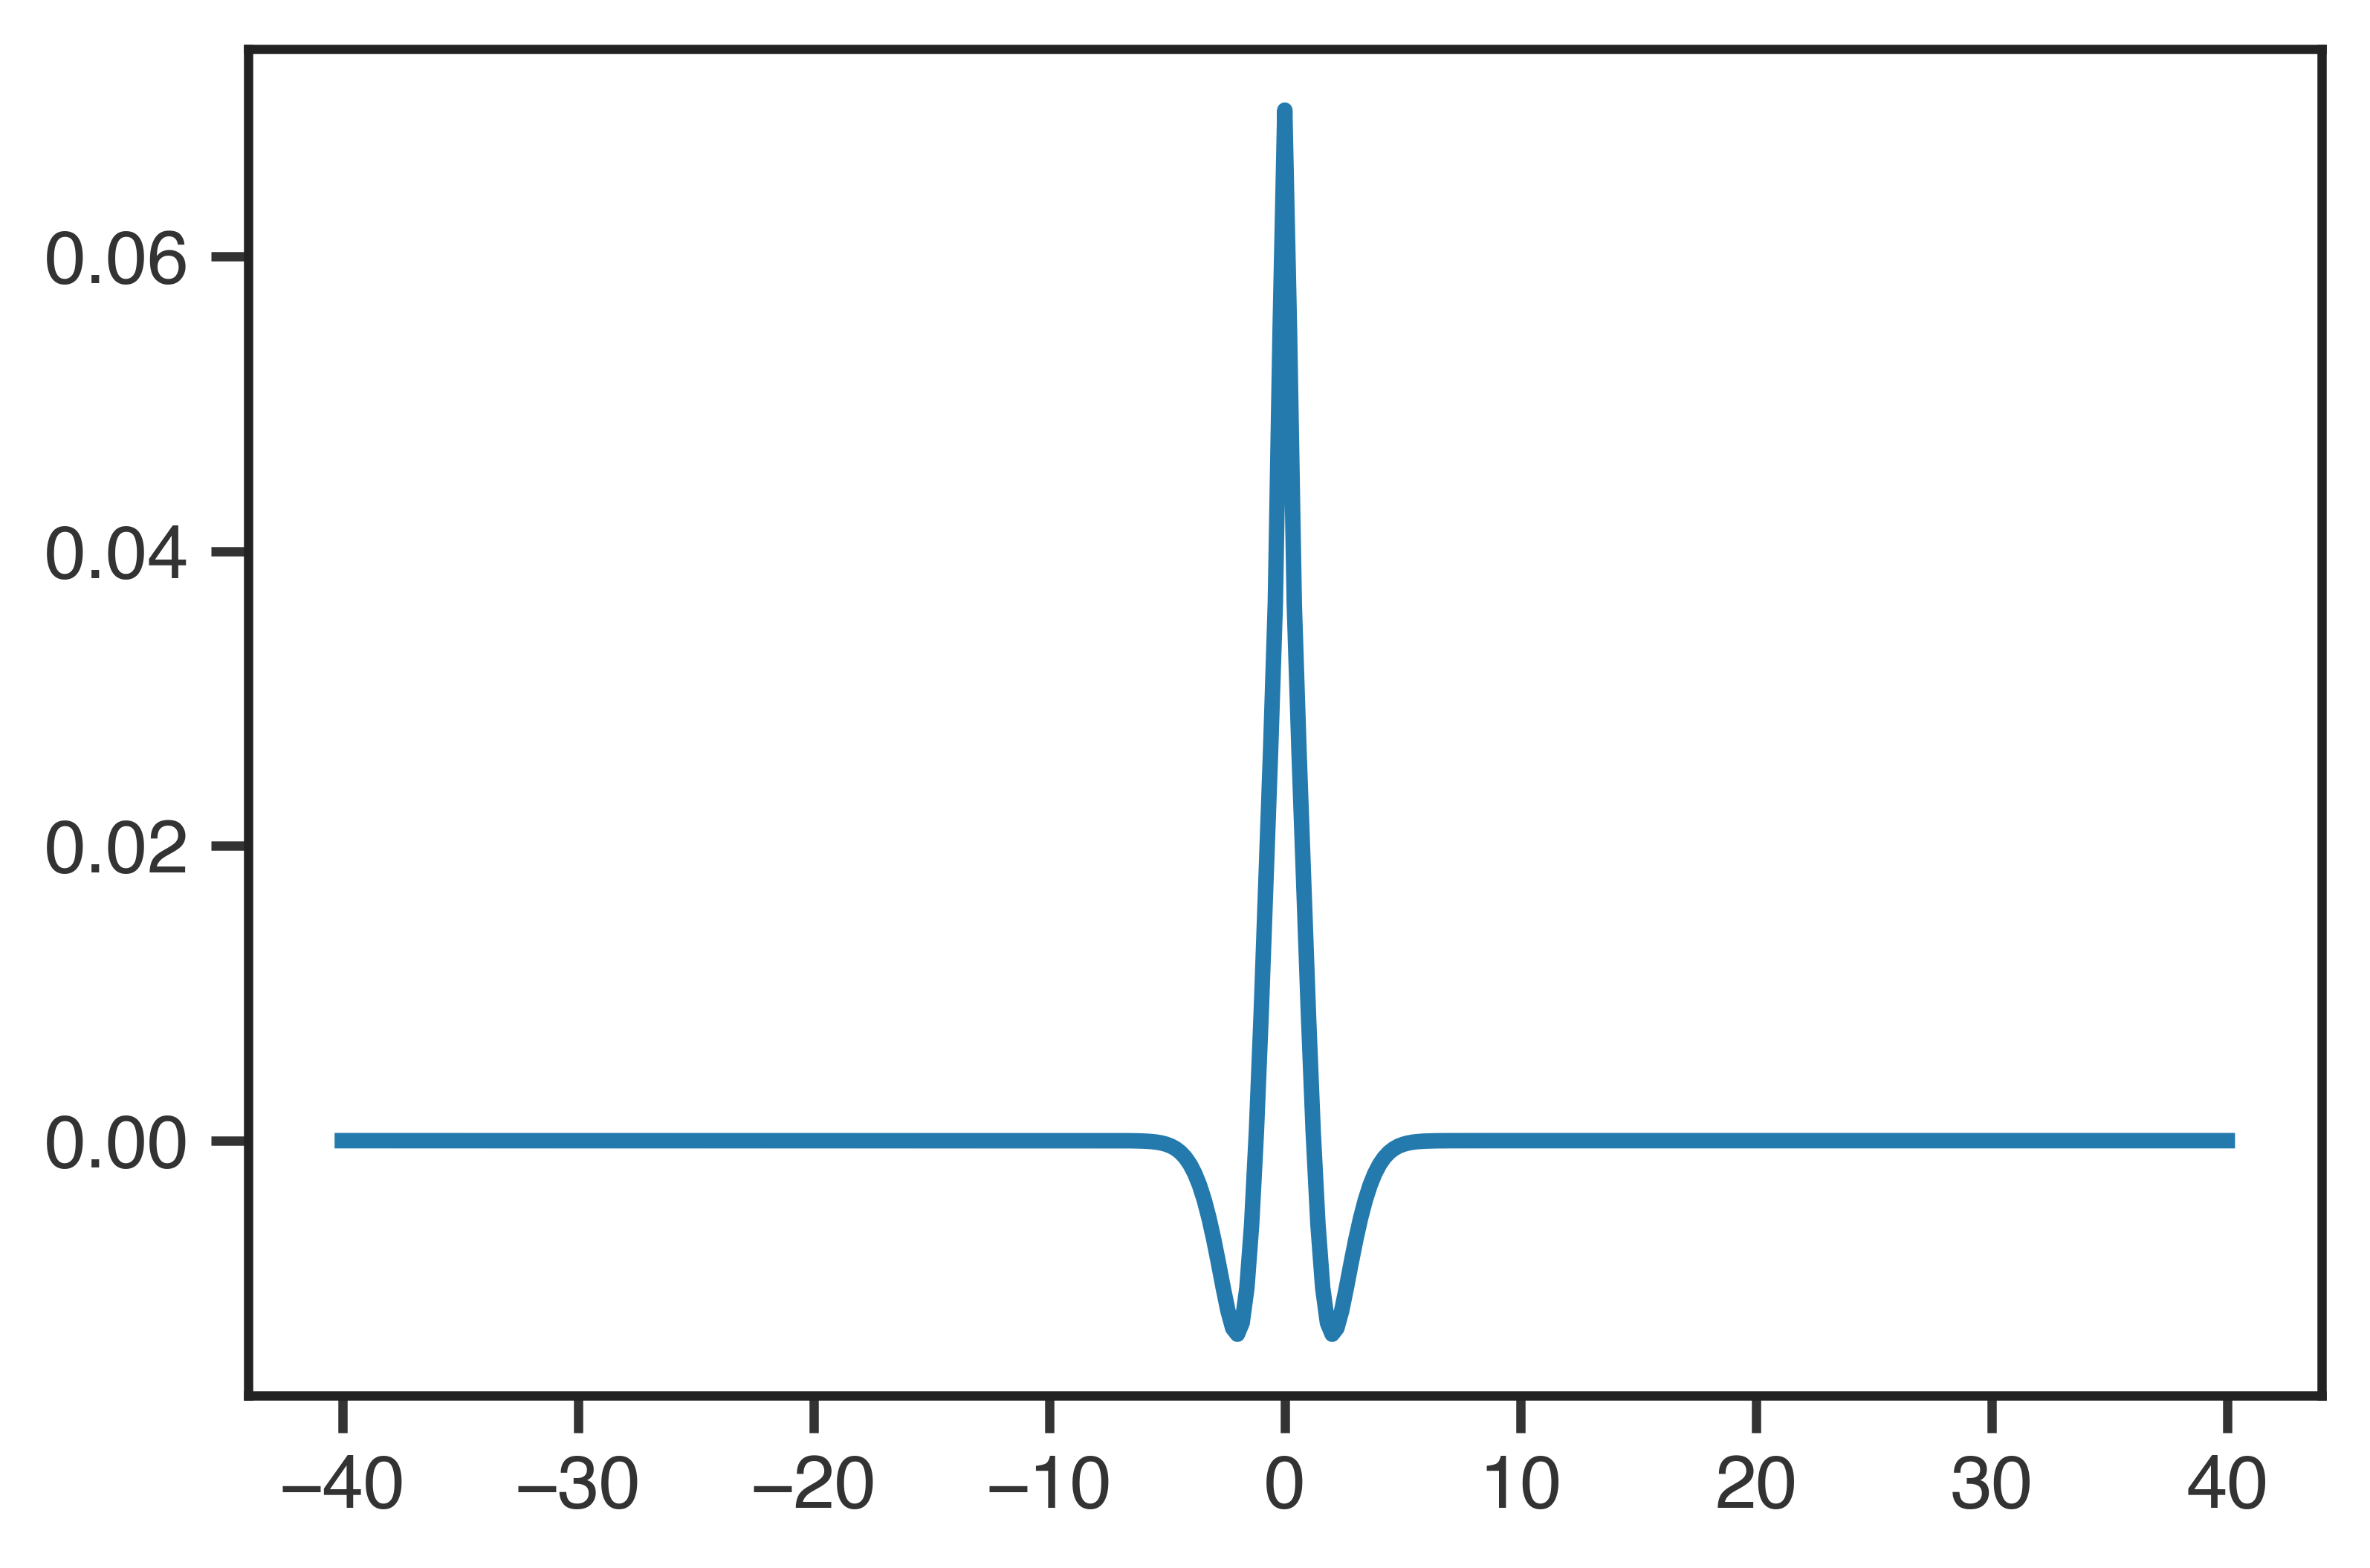

In [103]:
horz_weight = optimal_filters[0][0]
center_weight = optimal_filters[0][1]
horz_width = optimal_filters[0][2]
ama_width = optimal_filters[0][3]
plt.plot(space, variable_rf_model(horz_weight, center_weight, horz_width, ama_width))